In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import h5py
from numpy import ma as ma
from types import SimpleNamespace
# from crewmate.utils import quick_wigner, find_highest_populated_state
from scipy.optimize import curve_fit
from helpers import *

### Helpers

In [2]:
def compute_max_Fq(alpha):
    cdim = 30
    psi = (coherent(cdim, 0) + coherent(cdim, alpha)).unit()
    a = destroy(cdim)
    return 4 * (
        # np.abs(np.array(psi.dag() * (a.dag()*a)*(a.dag()*a) * psi)[0][0]) -
        # np.abs(np.array(psi.dag() * (a.dag()*a) * psi)[0][0]) ** 2
        np.abs(np.array(psi.dag() * (a.dag()*a)*(a.dag()*a) * psi)) -
        np.abs(np.array(psi.dag() * (a.dag()*a) * psi)) ** 2
    )

def compute_max_Fq_sqvac(coeff):
    cdim = 30
    psi = squeeze(cdim, coeff) * coherent(cdim, 0)
    a = destroy(cdim)
    return 4 * (
        # np.abs(np.array(psi.dag() * (a.dag()*a)*(a.dag()*a) * psi)[0][0]) -
        # np.abs(np.array(psi.dag() * (a.dag()*a) * psi)[0][0]) ** 2
        np.abs(np.array(psi.dag() * (a.dag()*a)*(a.dag()*a) * psi)) -
        np.abs(np.array(psi.dag() * (a.dag()*a) * psi)) ** 2
    )


# Ideal solution for large alpha


def probability_model(theta, alpha, amp, offset):
    return amp*(1
                + 2*np.exp(-np.abs(alpha)**2*(1-np.cos(theta))) *
                np.cos(np.abs(alpha)**2 * np.sin(theta))
                + np.exp(-2*np.abs(alpha)**2*(1-np.cos(theta)))) + offset

# Numerical solution without loss, ideal case


def ideal_numerical(alpha, c=0.5, theta=np.linspace(0, 1.6, 100)):
    cdim = 30
    cav_init = (
        np.sqrt(c) * coherent(cdim, 0) +
        np.sqrt(1-c) * coherent(cdim, alpha)
    ).unit()

    data = np.zeros(len(theta))
    for i in range(len(theta)):
        cav_final = (
            np.sqrt(c) * coherent(cdim, 0) +
            np.sqrt(1-c) * coherent(cdim, alpha * np.exp(1j*theta[i]))
        ).unit()
        data[i] = np.abs((cav_final.dag()*cav_init))**2
        # data[i] = np.abs((cav_final.dag()*cav_init)[0, 0])**2

    return data

In [3]:
theta_list = np.linspace(0, 1.6, 50)

THRESHOLDS = {
    '2023-09-01': .0001332709034396012,
    '2023-09-04': 0.00014097514035429803,
    '2023-09-08': 0.00013937012514173916,
    '2023-09-12': 0.00015,
    '2023-09-15': 0.00015,
    '2023-09-16': 0.00015,
    '2023-09-18': -0.00014703019609775395,
    '2023-09-19': -0.00014703019609775395,
    '2023-09-20': -0.00018678750221132843,
    '2023-09-21': -0.0001792569171426437,
    '2023-09-25': -0.00014956578372339103,
    '2023-09-26': -0.00014956578372339103,
    # New
    '2023-11-06': -3.8509558368547627e-05,
    '2023-11-07': -3.8509558368547627e-05,
    '2023-11-08': -3.4765634935704135e-05,
    '2023-11-13': -3.4765634935704135e-05,
    '2023-11-14': -3.4765634935704135e-05,
    '2023-11-15': -3.4765634935704135e-05,
    '2023-11-16': -3.4765634935704135e-05,
    '2023-12-06': -3.9836266556996435e-05,
    '2023-12-15': -3.4765634935704135e-05,
}

# Order of the polynomial fit for different alpha
POLYFIT_ORDER = {
    '0.5': 4,
    '0.75': 4,
    '1': 5,
    '1.25': 5,
    '1.5': 5,
    '1.6': 5,
    '1.75': 5,
    '2': 6,
    '2.1': 6,
    '2.2': 6,
    '2.3': 6,
    '2.4': 6,
    '2.5': 6,
}

# MEASURED_SQL = {
#     '0.5': 4 * 0.258**2 * 0.095,  # old: 0.077
#     '0.75': 4 * 0.4**2 * 0.127,
#     '1': 4 * 0.558**2 * 0.183,  # old: 0.3
#     '1.216': 4 * 0.707**2 * 0.544,
#     '1.25': 4 * 0.7321**2 * 0.192,
#     '1.5': 4 * 0.921**2 * 0.255,  # old: 0.405
#     '1.6': 4 * 1 ** 2 * 0.244,
#     '1.75': 4 * 1.122**2 * 0.276,
#     '2': 4 * 1.327**2 * 0.308,  # old: 0.5722640014577165
#     '2.1': 4 * 1.409**2 * 0.277,
#     '2.2': 4 * 1.49**2 * 0.28,
#     '2.3': 4 * 1.571**2 * 0.266,
#     '2.4': 4 * 1.651**2 * 0.276,
#     '2.5': 4 * 1.73**2 * 0.337  # old: 0.435
# }

MEASURED_SQL = {
    '0.5': 0.0944356168758636,
    '0.75': 0.6072815869351464,
    '1': 0.7554828730103511,
    '1.216': 4 * 0.707**2 * 0.544,
    '1.25': 1.1991102681923038,
    '1.5': 2.4170408210690564,
    '1.6': 2.553284098953605,
    '1.75': 3.3808403599295644,
    '2': 4.546765562346307
}

In [4]:
MEASURED_SQL['2']

4.546765562346307

# Phase estimation

## Quantum vs classical

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

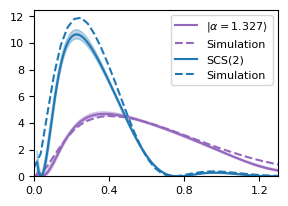

In [5]:
data_list = {
    'c2': load_experimental_data('pe/data/2023-11-13_c2.h5', THRESHOLDS['2023-11-13']),
    '2': load_experimental_data('pe/data/2023-11-13_alpha2.h5', THRESHOLDS['2023-11-13']),
}

sim_list = {
    '2': 'pe/sim/0_plus_alpha2_all.npz',
    'c2': 'pe/sim/alpha1327_all.npz',
}

colors = {
    # 'c2': ['tab:purple', 'tab:pink'],
    # '2': ['tab:blue', 'tab:cyan'],
    'c2': ['tab:purple', 'tab:purple'],
    '2': ['tab:blue', 'tab:blue'],
}

# fig = make_figure(width=6, height=4, font_size=8)
# ax0 = fig.add_subplot(111)
cm = 0.393701
fig = plt.subplots(figsize =(8*cm, 5.5*cm))

for name in list(data_list.keys()):
    data = data_list[name]
    pe = data.y
    phase = data.x

    up_lim = 1.6  # if float(alpha) > 1 else np.max(data.x) - 0.1
    x = np.linspace(np.max([np.min(phase), 0.01]), up_lim, 2000)

    if name[0] == 'c':
        order = 5
    else:
        order = 6  # POLYFIT_ORDER[name]
    # Data
    data_fit = np.polyfit(phase[phase < up_lim], pe[phase < up_lim], order)
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])
    mu, sigma = compute_many_FI_error(data, x, order, up_lim, 100)

    # Simulation
    if not sim_list[name]:
        continue
    sim = np.load(sim_list[name], 'r')
    phase_sim = sim['x']
    pe_sim = sim['probability_sim']
    x_sim = phase_sim[phase_sim <= max(x)]
    y_sim = pe_sim[phase_sim <= max(x)]
    FI_sim = compute_FI(y_sim, x_sim[1]-x_sim[0])


    # Add plots
    if colors[name]:
        col = colors[name]
    else:
        col = [None, None]
    if name[0] == 'c': lab = txt_ket(fr'\alpha={str(COH_MAP[name[1:]])}') #'classical'
    else: lab = f'SCS({name})'  #txt_ket(0) + '+' + txt_ket(fr"\alpha = {name}")
    plt.plot(x, FI_data, color=col[0], label=lab)
    plt.plot(x_sim, FI_sim, '--', markersize=3, color=col[1], label='Simulation')
    plt.fill_between(x, mu-sigma, mu+sigma, color=col[0], alpha=0.3)

plt.xlim([0, 1.3])
tick_start = 0
tick_end = 1.3
tick_step = 0.4
plt.xticks(np.arange(tick_start, tick_end, tick_step))
# ax0.set_title("Fisher Information for $n = 1$")
# ax0.set_xlabel("Phase [rad]")
# ax0.set_ylabel("Fisher Information")
plt.ylim([0, 12.5])
plt.legend(fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('FI_vs_phase.pdf')

In [8]:
sigma

array([0.89039537, 0.87157135, 0.83187998, ..., 0.39904998, 0.40541442,
       0.40843352])

### Offset

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

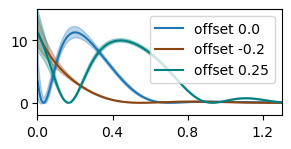

In [23]:
# alpha2_offsets = {
#     '0': load_experimental_data('pe/data/2023-11-13_alpha2.h5', THRESHOLDS['2023-11-13']),
#     '-0.1': load_experimental_data('pe/data/2023-11-15_alpha2_om01.h5', THRESHOLDS['2023-11-15']),
#     '-0.227': load_experimental_data('pe/data/2023-11-16_alpha2_om0227.h5', THRESHOLDS['2023-11-15']),
#     # '-0.3': load_experimental_data('pe/data/2023-11-15_alpha2_om03.h5', THRESHOLDS['2023-11-15']),
#     '0.2': load_experimental_data('pe/data/2023-11-16_alpha2_o02.h5', THRESHOLDS['2023-11-16']),
#     # '0.4': load_experimental_data('pe/data/2023-11-16_alpha2_o04.h5', THRESHOLDS['2023-11-16']),
#     # '0.6': load_experimental_data('pe/data/2023-11-16_alpha2_o06.h5', THRESHOLDS['2023-11-16']),
# }

alpha2_offsets = {
    # '0': load_experimental_data('pe/data/2023-11-13_alpha2.h5', THRESHOLDS['2023-11-13']),
    # '-0.1': load_experimental_data('pe/data/2023-11-15_alpha2_om01.h5', THRESHOLDS['2023-11-15']),
    '0.0': load_experimental_data('pe/data/2023-12-08_alpha2_o0.h5', THRESHOLDS['2023-12-06']),  
    '-0.2': load_experimental_data('pe/data/2023-12-08_alpha2_om02.h5', THRESHOLDS['2023-12-06']),
    # '-0.227': load_experimental_data('pe/data/2023-11-16_alpha2_om0227.h5', THRESHOLDS['2023-11-15']),
    # '-0.3': load_experimental_data('pe/data/2023-11-15_alpha2_om03.h5', THRESHOLDS['2023-11-15']),
    # '0.2': load_experimental_data('pe/data/2023-11-16_alpha2_o02.h5', THRESHOLDS['2023-11-16']), #2023-12-11_alpha2_o02.h5 
    # '0.2': load_experimental_data('pe/data/2023-12-11_alpha2_o02.h5', THRESHOLDS['2023-12-06']), #
    # '0.22': load_experimental_data('pe/data/2023-12-08_alpha2_o022.h5', THRESHOLDS['2023-12-06']),
    '0.25': load_experimental_data('pe/data/2023-12-08_alpha2_o025.h5', THRESHOLDS['2023-12-06']),
    # '0.27': load_experimental_data('pe/data/2023-12-08_alpha2_o027.h5', THRESHOLDS['2023-12-06']),
    # '0.3': load_experimental_data('pe/data/2023-12-08_alpha2_o03.h5', THRESHOLDS['2023-12-06']),
    # '0.4': load_experimental_data('pe/data/2023-11-16_alpha2_o04.h5', THRESHOLDS['2023-11-16']),
    # '0.6': load_experimental_data('pe/data/2023-11-16_alpha2_o06.h5', THRESHOLDS['2023-11-16']),
    
}

offset_data = alpha2_offsets

alphas = list(offset_data.keys())
np_alphas = np.array(alphas, dtype='float')

# fig = make_figure(width=4, height=4, font_size=8)
# ax0 = fig.add_subplot(111)

colorset = {'0.0': 'tab:blue',
            '-0.2': 'saddlebrown',
            '0.25': 'teal'}
cm = 0.393701
fig, ax0 = plt.subplots(figsize =(8*cm, 3.5*cm))
# fig, ax0 = plt.subplots(figsize =(3.5*cm, 3.5*cm))
for offset in offset_data:
    data = offset_data[offset]
    up_lim =  1.6
    x_dense = np.linspace(min(theta_list), up_lim, 2000)

    if offset == '0':
        order =  7 #10
    elif offset == '-0.1':
        order = 9
    elif offset == '-0.2':
        order = 5
    elif offset == '-0.227':
        order = 6
    elif offset == '-0.3':
        order = 6
    elif offset == '0.2':
        order = 7
    elif offset == '0.4':
        order = 5
    elif offset == '0.6':
        order = 7
    elif offset == '0.0':
        order = 7 # 6
    elif offset == '0.22':
        order = 7
    elif offset == '0.25':
        order = 6
    elif offset == '0.27':
        order = 5
    elif offset == '0.3':
        order = 5
    else:
        6

    # Data fit
    data_fit = np.polyfit(data.x[data.x <= up_lim],
                          data.y[data.x <= up_lim], order)
    # Experimental FI
    x = x_dense[(x_dense <= up_lim) & (x_dense > 0.0)]
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])
    mu, sigma = compute_many_FI_error(data, x, order, up_lim, 100)

    ax0.plot(x, FI_data, color=colorset[offset], label=f'offset {offset}')
    ax0.fill_between(x, mu-sigma, mu+sigma, color=colorset[offset], alpha=0.3)

# ax0.set_xlabel('Phase [rad]')
# ax0.set_ylabel('Fisher information')
ax0.set_xlim([0, 1.3])
ax0.set_ylim([-0, 20])
tick_start = 0
tick_end = 1.3
tick_step = 0.4
ax0.set_xticks(np.arange(tick_start, tick_end, tick_step))
ax0.legend()
plt.ylim(-2,15)
plt.savefig('fig3b.pdf')

### Different states

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

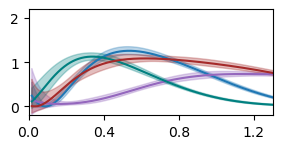

In [24]:
n05_states_data = {
    'cat_1216': load_experimental_data('pe/data/2023-11-16_alpha1216.h5', THRESHOLDS['2023-11-16']),
    'fock_1': load_experimental_data('pe/data/2023-11-16_fock1.h5', THRESHOLDS['2023-11-16']),
    'sqvac_0659': load_experimental_data('pe/data/2023-11-16_sqvac0659.h5', THRESHOLDS['2023-11-16']),
    'coherent': load_experimental_data('pe/data/2023-11-16_c0707.h5', THRESHOLDS['2023-11-16']),
}

# SQL_ideal = 4*compute_photon_number(1.6)
# SQL_measured = MEASURED_SQL['1.6']

alpha = 1.216
SQL_ideal = 4*compute_photon_number(alpha)
SQL_measured = MEASURED_SQL['1.216']

# fig = make_figure(width=4, height=4, font_size=8)
# ax0 = fig.add_subplot(111)


colorset = {'cat_1216': 'tab:blue',
            'fock_1': 'tab:purple',
            'sqvac_0659': 'teal',
            'coherent': 'brown'}


cm = 0.393701
# fig, ax0 = plt.subplots(figsize =(3.5*cm, 3.5*cm))

fig, ax0 = plt.subplots(figsize =(8*cm, 3.5*cm))

for alpha_coeff in list(n05_states_data.keys()):
    data = n05_states_data[alpha_coeff]
    pe = data.y
    phase = data.x

    up_lim = np.max(phase) if (np.max(phase) < 3) else 3
    x = np.linspace(np.max([np.min(phase), 0.01]), up_lim, 2000)

    
    if alpha_coeff == 'cat_1216':
        order = 5
        lab = 'SCS(1.216)'
    elif alpha_coeff == 'fock_1':
        order = 6
        lab = 'fock_1'
    elif alpha_coeff == 'sqvac_0659':
        order = 5
        lab = 'sqvac_0659'
    else:
        order = 6
        lab = 'coherent'
        

    data_fit = np.polyfit(phase[phase < up_lim], pe[phase < up_lim], order)
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])
    mu, sigma = compute_many_FI_error(data, x, order, up_lim, 100)

    # Label state (1-x)|0> + x|alpha>

    ax0.plot(x, FI_data, color=colorset[alpha_coeff], label=lab)
    ax0.fill_between(x, mu-sigma, mu+sigma, alpha=0.3, color=colorset[alpha_coeff])


# ax0.axhline(y=SQL_measured, color='red', label='Measured SQL')
ax0.set_xlim([0, 1.3])
ax0.set_ylim([-0.2,2.2])
# ax0.set_xlabel("Phase [rad]")
# ax0.set_ylabel("FI")
# ax0.legend()
tick_start = 0
tick_end = 1.3
tick_step = 0.4
ax0.set_xticks(np.arange(tick_start, tick_end, tick_step))
plt.savefig('sfig2a.pdf')

## Photon number scaling

### SCS vs n

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

[1.0083255780961802, 0.9570547859895947, 0.8374229377408954, 1.0083255780961802, 0.8374229377408954, 1.0083255780961802, 1.0083255780961802, 0.9570547859895947, 0.9741450500251232, 1.0083255780961802, 1.0083255780961802, 0.9912353140606517, 1.0083255780961802, 0.9912353140606517, 0.8545132017764239, 0.9057839938830092, 0.9912353140606517, 0.9399645219540662, 0.9399645219540662, 0.8545132017764239, 1.0083255780961802, 0.9399645219540662, 1.0083255780961802, 0.8203326737053669, 1.0083255780961802, 1.0083255780961802, 0.8886937298474809, 1.0083255780961802, 1.0083255780961802, 0.9570547859895947, 0.8886937298474809, 0.9399645219540662, 0.8545132017764239, 1.0083255780961802, 1.0083255780961802, 0.9570547859895947, 0.9399645219540662, 1.0083255780961802, 1.0083255780961802, 0.9057839938830092, 1.0083255780961802, 0.8545132017764239, 0.8716034658119524, 1.0083255780961802, 1.0083255780961802, 0.8545132017764239, 0.9228742579185377, 1.0083255780961802, 1.0083255780961802, 1.0083255780961802,

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

[0.7007008254566676, 0.7007008254566676, 0.6665202973856106, 0.5297981851013828, 0.8374229377408954, 0.6323397693145536, 0.6665202973856106, 0.5981592412434967, 0.7348813535277245, 0.7690618815987814, 0.6665202973856106, 0.7348813535277245, 0.5981592412434967, 0.8716034658119524, 0.7007008254566676, 0.8032424096698384, 0.7348813535277245, 0.7007008254566676, 0.7348813535277245, 0.7007008254566676, 0.7007008254566676, 0.6665202973856106, 0.7348813535277245, 0.7690618815987814, 0.08545132017764238, 0.08545132017764238, 0.7007008254566676, 0.6665202973856106, 0.6323397693145536, 0.7007008254566676, 0.7007008254566676, 0.7007008254566676, 0.7690618815987814, 0.7690618815987814, 0.5981592412434967, 0.5981592412434967, 0.7007008254566676, 0.7007008254566676, 0.49561765703032584, 0.7007008254566676, 0.7348813535277245, 0.7007008254566676, 0.7348813535277245, 0.7690618815987814, 0.6665202973856106, 0.5297981851013828, 0.5981592412434967, 0.6323397693145536, 0.7348813535277245, 0.63233976931455

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

[0.5639787131724397, 0.5468884491369113, 0.5468884491369113, 0.5810689772079682, 0.5468884491369113, 0.5468884491369113, 0.5297981851013828, 0.5639787131724397, 0.5468884491369113, 0.5639787131724397, 0.5639787131724397, 0.5297981851013828, 0.5468884491369113, 0.5639787131724397, 0.5639787131724397, 0.5468884491369113, 0.5468884491369113, 0.5810689772079682, 0.5468884491369113, 0.5810689772079682, 0.5468884491369113, 0.5639787131724397, 0.5468884491369113, 0.5639787131724397, 0.5127079210658543, 0.5810689772079682, 0.5297981851013828, 0.5810689772079682, 0.5297981851013828, 0.5127079210658543, 0.5981592412434967, 0.5639787131724397, 0.5468884491369113, 0.5297981851013828, 0.5297981851013828, 0.5127079210658543, 0.5639787131724397, 0.5639787131724397, 0.5468884491369113, 0.5127079210658543, 0.5468884491369113, 0.5639787131724397, 0.5127079210658543, 0.5981592412434967, 0.5297981851013828, 0.5297981851013828, 0.5468884491369113, 0.5468884491369113, 0.5468884491369113, 0.5468884491369113,

/Users/panxiaozhou/Documents/GitHub/Metrology_project/protocol_simulation/panda4/helpers.py:56: RuntimeWarning: divide by zero encountered in divide
  return (dy**2 / (y) + dy**2 / (1-y)) # 这里简化了公式,对于binary measurement， dy是一样的


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

[0.5297981851013828, 0.49561765703032584, 0.42725660088821193, 0.49561765703032584, 0.49561765703032584, 0.46143712895926886, 0.49561765703032584, 0.5639787131724397, 0.46143712895926886, 0.49561765703032584, 0.5297981851013828, 0.49561765703032584, 0.46143712895926886, 0.42725660088821193, 0.5297981851013828, 0.5297981851013828, 0.5297981851013828, 0.49561765703032584, 0.46143712895926886, 0.5639787131724397, 0.5297981851013828, 0.46143712895926886, 0.5639787131724397, 0.5297981851013828, 0.49561765703032584, 0.42725660088821193, 0.5639787131724397, 0.5297981851013828, 0.5639787131724397, 0.49561765703032584, 0.5297981851013828, 0.49561765703032584, 0.49561765703032584, 0.49561765703032584, 0.5297981851013828, 0.49561765703032584, 0.46143712895926886, 0.5981592412434967, 0.5297981851013828, 0.49561765703032584, 0.49561765703032584, 0.5297981851013828, 0.46143712895926886, 0.49561765703032584, 0.6323397693145536, 0.49561765703032584, 0.5297981851013828, 0.5981592412434967, 0.5639787131

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

[0.34180528071056954, 0.32471501667504105, 0.32471501667504105, 0.32471501667504105, 0.34180528071056954, 0.32471501667504105, 0.34180528071056954, 0.34180528071056954, 0.34180528071056954, 0.34180528071056954, 0.34180528071056954, 0.34180528071056954, 0.34180528071056954, 0.32471501667504105, 0.34180528071056954, 0.32471501667504105, 0.34180528071056954, 0.34180528071056954, 0.32471501667504105, 0.358895544746098, 0.34180528071056954, 0.34180528071056954, 0.32471501667504105, 0.34180528071056954, 0.34180528071056954, 0.358895544746098, 0.34180528071056954, 0.34180528071056954, 0.32471501667504105, 0.34180528071056954, 0.34180528071056954, 0.34180528071056954, 0.34180528071056954, 0.32471501667504105, 0.34180528071056954, 0.34180528071056954, 0.32471501667504105, 0.32471501667504105, 0.32471501667504105, 0.32471501667504105, 0.32471501667504105, 0.34180528071056954, 0.34180528071056954, 0.32471501667504105, 0.34180528071056954, 0.32471501667504105, 0.34180528071056954, 0.34180528071056

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

[0.3076247526395126, 0.3076247526395126, 0.32471501667504105, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.2905344886039841, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.32471501667504105, 0.32471501667504105, 0.2905344886039841, 0.3076247526395126, 0.3076247526395126, 0.32471501667504105, 0.3076247526395126, 0.3076247526395126, 0.2905344886039841, 0.2905344886039841, 0.3076247526395126, 0.3076247526395126, 0.2905344886039841, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.32471501667504105, 0.3076247526395126, 0.3076247526395126, 0.32471501667504105, 0.3076247526395126, 0.3076247526395126, 0.32471501667504105, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.32471501667504105, 0.3076247526395126, 0.3076247526395126, 0.3076247526395126, 0.324715016

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

[0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.25635396053292714, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.25635396053292714, 0.25635396053292714, 0.2905344886039841, 0.25635396053292714, 0.2905344886039841, 0.25635396053292714, 0.25635396053292714, 0.25635396053292714, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.25635396053292714, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.25635396053292714, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.2905344886039841, 0.29053448

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

[0.2221734324618702, 0.23926369649739868, 0.23926369649739868, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.23926369649739868, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.23926369649739868, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.23926369649739868, 0.2221734324618702, 0.2221734324618702, 0.23926369649739868, 0.2221734324618702, 0.23926369649739868, 0.23926369649739868, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.23926369649739868, 0.23926369649739868, 0.2221734324618702, 0.2221734324618702, 0.20508316842634172, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.23926369649739868, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.2221734324618702, 0.20508316842634172, 0.2221734324618702, 0.2392

  0%|          | 0/149 [00:00<?, ?it/s]

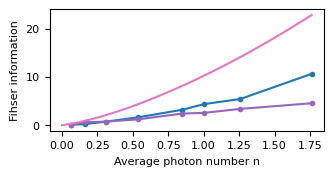

In [25]:
alpha_data = {
    '0.5': load_experimental_data('pe/data/2023-11-13_alpha05.h5', THRESHOLDS['2023-11-13']),
    '0.75': load_experimental_data('pe/data/2023-11-14_alpha075.h5', THRESHOLDS['2023-11-14']),
    '1': load_experimental_data('pe/data/2023-11-13_alpha1.h5', THRESHOLDS['2023-11-13']),
    '1.25': load_experimental_data('pe/data/2023-11-14_alpha125.h5', THRESHOLDS['2023-11-14']),
    '1.5': load_experimental_data('pe/data/2023-11-13_alpha15.h5', THRESHOLDS['2023-11-13']),
    '1.6': load_experimental_data('pe/data/2023-11-13_alpha16.h5', THRESHOLDS['2023-11-13']),
    '1.75': load_experimental_data('pe/data/2023-11-14_alpha175.h5', THRESHOLDS['2023-11-14']),
    '2': load_experimental_data('pe/data/2023-11-13_alpha2.h5', THRESHOLDS['2023-11-13']),
    # '2.1': load_experimental_data('pe/data/2023-11-21_alpha21.h5', THRESHOLDS['2023-11-13']),
    # '2.2': load_experimental_data('pe/data/2023-11-17_alpha22.h5', THRESHOLDS['2023-11-13']),
    # '2.3': load_experimental_data('pe/data/2023-11-17_alpha23.h5', THRESHOLDS['2023-11-13']),
    # '2.4': load_experimental_data('pe/data/2023-11-17_alpha24.h5', THRESHOLDS['2023-11-13']),
    # '2.5': load_experimental_data('pe/data/2023-11-17_alpha25.h5', THRESHOLDS['2023-11-13']),
}

alpha_sim = {
    '0.5': 'pe/sim/0_plus_alpha05_all.npz',
    '0.75': 'pe/sim/0_plus_alpha075_all.npz',
    '1': 'pe/sim/0_plus_alpha1_all.npz',
    '1.25': 'pe/sim/0_plus_alpha125_all.npz',
    '1.5': 'pe/sim/0_plus_alpha15_all.npz',
    '1.6': 'pe/sim/0_plus_alpha16_all.npz',
    '1.75': 'pe/sim/0_plus_alpha175_all.npz',
    '2': 'pe/sim/0_plus_alpha2_all.npz',
    '2.1': 'pe/sim/0_plus_alpha21_all.npz',
    '2.2': 'pe/sim/0_plus_alpha22_all.npz',
    # '2.3': 'pe/sim/0_plus_alpha23_all.npz',
    # '2.4': 'pe/sim/0_plus_alpha24_all.npz',
    # '2.5': 'pe/sim/0_plus_alpha25_all.npz',
}

coherent_data = {
    '0.5': load_experimental_data('pe/data/2023-11-13_c05.h5', THRESHOLDS['2023-11-13']),
    '0.75': load_experimental_data('pe/data/2023-11-14_c075.h5', THRESHOLDS['2023-11-14']),
    '1': load_experimental_data('pe/data/2023-11-13_c1.h5', THRESHOLDS['2023-11-13']),
    '1.25': load_experimental_data('pe/data/2023-11-14_c125.h5', THRESHOLDS['2023-11-14']),
    '1.5': load_experimental_data('pe/data/2023-11-13_c15.h5', THRESHOLDS['2023-11-13']),
    '1.6': load_experimental_data('pe/data/2023-11-14_c16.h5', THRESHOLDS['2023-11-14']),
    '1.75': load_experimental_data('pe/data/2023-11-14_c175.h5', THRESHOLDS['2023-11-14']),
    '2': load_experimental_data('pe/data/2023-11-13_c2.h5', THRESHOLDS['2023-11-13']),
}

coherent_sim = {
    '0.5': 'pe/sim/alpha0258_all.npz',
    '0.75': 'pe/sim/alpha04_all.npz',
    '1': 'pe/sim/alpha0558_all.npz',
    '1.25': 'pe/sim/alpha0732_all.npz',
    '1.5': 'pe/sim/alpha0921_all.npz',
    '1.6': 'pe/sim/alpha1_all.npz',
    '1.75': 'pe/sim/alpha1122_all.npz',
    '2': 'pe/sim/alpha1327_all.npz',
}

fig = make_figure()
ax0 = fig.add_subplot(111)

alphas = list(alpha_data.keys())
np_alphas = np.array(alphas, dtype='float')

# SCS exp data
result_max = []
result_max_var = []
result_avg = []
result_bandwidth = []
result_th_max = []
result_slope = []
result_sigma = []
result_phase_at_optimal = []

# SCS exp_sim data
result_sim_max = []
result_sim_avg = []
result_sim_bandwidth = []
sim_th_max = []

result_ideal_max = []
result_ideal_avg = []
result_ideal_bandwidth = []
offset_error_array = []

# coh exp data
coh_max = []
coh_max_var = []
coh_slope = []
coh_sigma = []

# coh sim data
coh_sim_max = []
coh_sim_bandwidth = []

for alpha in alpha_data:
    data = alpha_data[alpha]
    # np.max(data.x) - 0.1 if (np.max(data.x) < 3) else 3
    up_lim = 1.6 if float(alpha) > 1 else np.max(data.x) - 0.1
    x_dense = np.linspace(min(theta_list), up_lim, 2000)
    # Data fit
    data_fit = np.polyfit(data.x[data.x < up_lim], data.y[data.x < up_lim], POLYFIT_ORDER[alpha])
    # Experimental FI
    x = x_dense[(x_dense < up_lim) & (x_dense > 0.1)]
    y_fit = np.poly1d(data_fit)(x)
    m, a, b, mx = extract_FI_params(x, y_fit, MEASURED_SQL[alpha])
    # dth, var_th, slope = estimate_delta_theta(data, y_fit, x)
    dth, var_th, slope, idx_data = estimate_delta_theta(data, y_fit, x)
    mu, sigma = compute_many_FI_error(data, x, POLYFIT_ORDER[alpha], up_lim, 100)
    _, _, offset_error = compute_many_FI_error_offset(data, x, POLYFIT_ORDER[alpha], up_lim, 100)
    result_max.append(m)
    result_avg.append(a)
    offset_error_array.append(offset_error)

    result_bandwidth.append(b)
    result_max_var.append(1/dth)
    result_th_max.append(mx)
    result_slope.append(slope)
    result_sigma.append(sigma[np.argmax(compute_FI(y_fit, x[1]-x[0]))])
    result_phase_at_optimal.append(data.x[idx_data])

    # save data which is the pg0 matrix
    data_save = np.column_stack((data.x, (data.mg0).T))
    header = 'x ' + ' '.join([f'{i+1}' for i in range(data.mg0.shape[1])])

    np.savetxt(f'0_plus_{alpha}.csv',data_save, delimiter=',', header=header, fmt='%.2f')
    # print(np.shape(data_save))

    data_save_fitting = np.column_stack((x, y_fit))
    np.savetxt(f'0_plus_{alpha}_fitting.csv',data_save_fitting, delimiter=',', header='x_fitting, y_fitting', fmt='%.3f')

    # Simulation FI
    sim = np.load(alpha_sim[alpha], 'r')
    phase_sim = sim['x']
    pe_sim = sim['probability_sim']
    x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
    y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
    m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
    result_sim_max.append(m)
    result_sim_avg.append(a)
    result_sim_bandwidth.append(b)
    sim_th_max.append(mx)

    # Ideal FI
    x = np.linspace(0,2.5, 500) #theta_list
    y = ideal_numerical(float(alpha), 0.5, x)
    m, a, b, _ = extract_FI_params(x, y, MEASURED_SQL[alpha])
    result_ideal_max.append(compute_max_Fq(float(alpha)))
    result_ideal_avg.append(a)
    result_ideal_bandwidth.append(b)

    # Classical
    data_c = coherent_data[alpha]
    pe_c = data_c.y
    phase_c = data_c.x
    up_lim = np.max(phase_c) - 0.1
    data_fit_c = np.polyfit(phase_c[phase_c < up_lim], pe_c[phase_c < up_lim], 5)
    x_dense = np.linspace(min(theta_list), (up_lim if up_lim < 4 else 4), 2000)
    x = x_dense[(x_dense < (up_lim if up_lim < 4 else 4)) & (x_dense > 0.1)]
    y_fit_c = np.poly1d(data_fit_c)(x)

    
    m, a, b, mx = extract_FI_params(x, y_fit_c, MEASURED_SQL[alpha])
    # dth, _, slope = estimate_delta_theta(data_c, y_fit_c, x)
    dth, _, slope, _ = estimate_delta_theta(data_c, y_fit_c, x)
    # print(dth)
    mu, sigma = compute_many_FI_error(data_c, x, 5, up_lim, 100)
    coh_sigma.append(sigma[np.argmax(compute_FI(y_fit_c, x[1]-x[0]))])
    coh_max.append(m)
    
    coh_max_var.append(1/dth)
    coh_slope.append(slope)
    

    # Classical simulation FI
    sim_c = np.load(coherent_sim[alpha], 'r')
    phase_sim_c = sim_c['x']
    pe_sim_c = sim_c['probability_sim']
    x_sim_c = phase_sim_c[phase_sim_c <= max(x_dense) if alpha != '2.5' else phase_sim_c <= 0.6]
    y_sim_c = pe_sim_c[phase_sim_c <= max(x_dense) if alpha != '2.5' else phase_sim_c <= 0.6]
    m, a, b, mx = extract_FI_params(x_sim_c, y_sim_c, MEASURED_SQL[alpha])
    coh_sim_max.append(m)
    coh_sim_bandwidth.append(b)



n = [compute_photon_number(v) for v in np_alphas]
v = np.linspace(0,2,200)

# Fisher information plot
ax0.plot(n, result_max, '.-', color='tab:blue', label="Measured FI max")
# ax0.plot(n, result_avg, '.-', color='tab:cyan', label="Measured FI avg")
ax0.plot(n, [MEASURED_SQL[alpha] for alpha in alphas], '.-', color='tab:purple', label="Measured SQL")
ax0.plot([compute_photon_number(w) for w in v], [compute_max_Fq(w) for w in v], color='tab:pink', label="Ideal max")

# plt.legend()
# plt.title('Phase estimation with balanced cat states')
ax0.set_xlabel(r"Average photon number n")
ax0.set_ylabel("Fihser information")
plt.show()

In [9]:
print('optimal phase (rad):', np.around(result_phase_at_optimal,3))

optimal phase (rad): [0.974 0.701 0.547 0.496 0.342 0.308 0.291 0.222]


### Save the data at optimal Fisher information, used for Bayesian estimation

mx_e_test: [[1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 1 1]]
mx_g: [[1 1 1 ... 0 1 --]
 [1 1 1 ... 0 0 --]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... -- 1 0]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... -- 1 0]]
mg0: [[1.0 1.0 1.0 ... 0.0 1.0 0.0]
 [1.0 1.0 1.0 ... 0.0 0.0 0.0]
 [1.0 1.0 1.0 ... 1.0 1.0 1.0]
 ...
 [1.0 1.0 1.0 ... 0.0 1.0 0.0]
 [1.0 1.0 1.0 ... 0.0 0.0 1.0]
 [1.0 1.0 1.0 ... 0.0 1.0 0.0]]


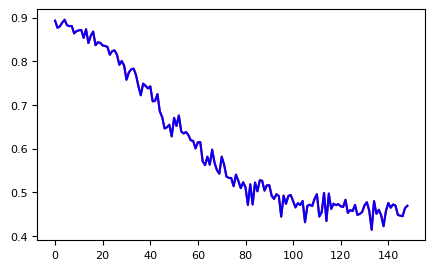

In [57]:
print('mx_e_test:', alpha_data['1'].mx_e_test)
print('mx_g:', alpha_data['1'].y_raw)
print('mg0:', alpha_data['1'].mg0)
# print('y:', alpha_data['0.5'].y)
plt.figure(figsize=(5,3))
plt.plot(alpha_data['1'].mg0.mean(0),'r')
plt.plot(alpha_data['1'].y, 'b')




In [76]:
alpha_data['1'].x[1] - alpha_data['1'].x[0]

0.017090264035528477

(149, 1001)
[0.02 0.03 0.05 0.07 0.09 0.1  0.12 0.14 0.15 0.17 0.19 0.21 0.22 0.24
 0.26 0.27 0.29 0.31 0.32 0.34 0.36 0.38 0.39 0.41 0.43 0.44 0.46 0.48
 0.5  0.51 0.53 0.55 0.56 0.58 0.6  0.62 0.63 0.65 0.67 0.68 0.7  0.72
 0.73 0.75 0.77 0.79 0.8  0.82 0.84 0.85 0.87 0.89 0.91 0.92 0.94 0.96
 0.97 0.99 1.01 1.03 1.04 1.06 1.08 1.09 1.11 1.13 1.15 1.16 1.18 1.2
 1.21 1.23 1.25 1.26 1.28 1.3  1.32 1.33 1.35 1.37 1.38 1.4  1.42 1.44
 1.45 1.47 1.49 1.5  1.52 1.54 1.56 1.57 1.59 1.61 1.62 1.64 1.66 1.67
 1.69 1.71 1.73 1.74 1.76 1.78 1.79 1.81 1.83 1.85 1.86 1.88 1.9  1.91
 1.93 1.95 1.97 1.98 2.   2.02 2.03 2.05 2.07 2.09 2.1  2.12 2.14 2.15
 2.17 2.19 2.2  2.22 2.24 2.26 2.27 2.29 2.31 2.32 2.34 2.36 2.38 2.39
 2.41 2.43 2.44 2.46 2.48 2.5  2.51 2.53 2.55]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 1. 0. 1.]
 [0. 0. 1. ... 0. 1. 0.]]
[0.89318413 0.87692308 0.88012295 0.88877446 0.89527721 0.88295688
 0.880658

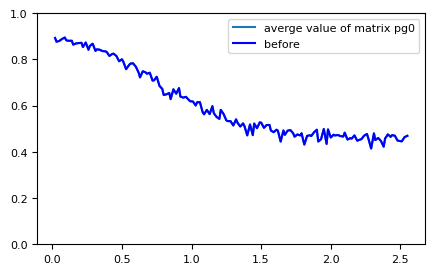

In [15]:
# file05 = np.loadtxt('0_plus_0.5.csv', delimiter=',',skiprows=1)
file05 = np.array( np.loadtxt('0_plus_1.csv', delimiter=',', skiprows=1))
data_x = file05[:, 0]
data_y = file05[:, 1:]
data_y_mean = np.nanmean(data_y, axis=1)
print(file05.shape)
print(data_x)
print(data_y)
print(data_y_mean)
print(type(file05[:, 1:]))
plt.figure(figsize=(5, 3))
plt.plot(data_x, data_y_mean, label='averge value of matrix pg0' )
# plt.plot(data_x,alpha_data['1'].mg0.mean(0),'r')
plt.plot(data_x, alpha_data['1'].y, 'b', label='before')
plt.ylim(0,1)
plt.legend()



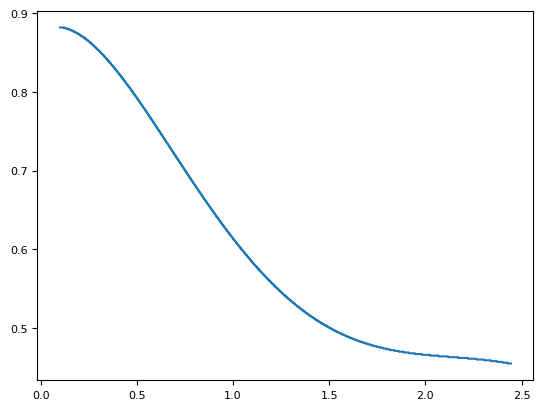

In [18]:
file_1_fitting = np.array( np.loadtxt('0_plus_1_fitting.csv', delimiter=',', skiprows=1))
data_x = file_1_fitting[:, 0]
data_y = file_1_fitting[:, 1]
plt.plot(data_x,data_y)

[ 1.15520037  0.25052599  0.11909944 -0.10816344 -0.49296912 -0.51280958
 -0.65742474 -0.76621231]
Optimized Parameters:
b: -0.9145257494038098
a: -0.9874286158816521
c: 0.0
---------------
Optimized Parameters:
b: -0.46365262822108483
a: -0.5075706566316787
c: 0.0


/var/folders/f5/st3433753w308xlm5y62ttnc0000gn/T/ipykernel_28526/1610881621.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(fit, log_x[1:], log_y[1:], p0=[1, -1, 0])
/var/folders/f5/st3433753w308xlm5y62ttnc0000gn/T/ipykernel_28526/1610881621.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(fit, log_x[1:], log_y2[1:], p0=[1, -1, 0])


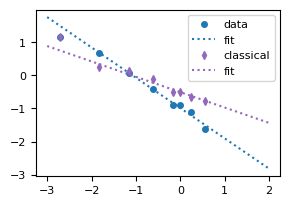

In [ ]:
from scipy.optimize import curve_fit
def fit(avg_num, b, a, c):
    return b * avg_num + a


log_x = np.log(n)
log_y = np.log(np.sqrt(np.array(1/np.array(result_max_var))))
params, covariance = curve_fit(fit, log_x[1:], log_y[1:], p0=[1, -1, 0])
op_b1, op_a1, op_c1 = params

log_y2 = np.log(np.sqrt(np.array(1/np.array(coh_max_var))))
params, covariance = curve_fit(fit, log_x[1:], log_y2[1:], p0=[1, -1, 0])
op_b2, op_a2, op_c2 = params


cm = 0.393701
fig = plt.subplots(figsize =(8*cm, 5.5*cm))

plt.plot(log_x, log_y, color='tab:blue', linestyle='', markersize=4, marker='o', label='data')
v = np.linspace(-3,2,50)
plt.plot(v, fit(v, op_b1, op_a1, op_c1), ':',color='tab:blue', label='fit')

plt.plot(log_x, log_y2, color='tab:purple', linestyle='', markersize=4, marker='d', label='classical')
plt.plot(v, fit(v, op_b2, op_a2, op_c2), ':',color='tab:purple', label='fit')

print(log_y2)

# ax0.set_xlabel(r'log(n)')
# ax0.set_ylabel(r'log($\Delta\theta$)')
# ax0.set_title('Phase estimation error scaling')
# plt.xlim([-2, 0.7])
# plt.ylim([-1.8, 1.1])


# plt.plot(v, fit(v,  -1, 0, 0),'-', color='green', label='HL')
# plt.plot(v, fit(v,  -0.5, 0, 0),'-',color='orange', label='SQL')


plt.legend(fontsize=8)
print("Optimized Parameters:")
print("b:", op_b1)
print("a:", op_a1)
print("c:", op_c1)
print('---------------')
print("Optimized Parameters:")
print("b:", op_b2)
print("a:", op_a2)
print("c:", op_c2)
plt.tick_params(axis='both', which='major', labelsize=8)
# plt.savefig('phase_direct_measurement.pdf')

In [ ]:
print(log_y2)

[ 1.15520037  0.25052599  0.11909944 -0.10816344 -0.49296912 -0.51280958
 -0.65742474 -0.76621231]


In [ ]:
alpha_data = {
    '0.5': load_experimental_data('pe/data/2023-11-13_alpha05.h5', THRESHOLDS['2023-11-13']),
    '0.75': load_experimental_data('pe/data/2023-11-14_alpha075.h5', THRESHOLDS['2023-11-14']),
    '1': load_experimental_data('pe/data/2023-11-13_alpha1.h5', THRESHOLDS['2023-11-13']),
    '1.25': load_experimental_data('pe/data/2023-11-14_alpha125.h5', THRESHOLDS['2023-11-14']),
    '1.5': load_experimental_data('pe/data/2023-11-13_alpha15.h5', THRESHOLDS['2023-11-13']),
    '1.6': load_experimental_data('pe/data/2023-11-13_alpha16.h5', THRESHOLDS['2023-11-13']),
    '1.75': load_experimental_data('pe/data/2023-11-14_alpha175.h5', THRESHOLDS['2023-11-14']),
    '2': load_experimental_data('pe/data/2023-11-13_alpha2.h5', THRESHOLDS['2023-11-13']),
}

# cm = 0.393701
# fig = plt.subplots(figsize =(8*cm, 5.5*cm))
# ax0 = fig.add_subplot(111)
n_boot = 100
# colors = {
#     'SCS': ['tab:blue', 'o'],
#     'SQL': ['tab:purple', 'd'],
# }
difference_SCS=[]
for name in alpha_data:
    data = alpha_data[name]
    x_len = len(data.x)
    mu_boot_g = np.zeros([n_boot, x_len])
    mu_boot_g_dp = np.zeros([n_boot, x_len])
    mu_boot_gvac = np.zeros([n_boot, x_len])
    mu_boot_gvac_dp = np.zeros([n_boot, x_len])
    sigma_tot = np.zeros(x_len)

    # scs 
    up_lim = 1.6
    x_dense = np.linspace(0, up_lim, 2000)
    # data fit
    data_fit = np.polyfit(data.x[data.x < up_lim], data.y[data.x < up_lim], POLYFIT_ORDER[name])
    y_fit = np.poly1d(data_fit)(x_dense)
    FI = compute_FI(y_fit, x_dense[1]-x_dense[0])
    # print(len(FI))
    # Get the optimal point from fitting data
    idx = np.argmax(FI)
    # Index for experimental data
    idx_data = np.argmin(np.abs(data.x - x_dense[idx]))
    opt_slope = np.gradient(y_fit, x_dense[1]-x_dense[0])[idx]
    
    # # Get optimal data
    m1 = data.m1
    mx_g = data.y_raw
    opt_p_g = 1 - m1[:, idx_data]
    opt_p_gvac = mx_g[:, idx_data]
    var_opt_p = np.var(opt_p_g * opt_p_gvac)

    for i in range(x_len):
        # First measurement, g
        # _, _, mu_boot_g[:,i] = bootstrap(data.m1[:, i], n_boot)
        _, _, mu_boot_g[:,i], mu_boot_g_dp[:,i] = bootstrap_dp(data.m1[:, i], n_boot)

        # Second measurement, g vac
        _, _, mu_boot_gvac[:, i], mu_boot_gvac_dp[:,i] = bootstrap_dp(data.y_raw[:, i], n_boot)

    mu_g_g_vac_boot_dp = mu_boot_g_dp * mu_boot_gvac_dp

    var_mu_g_g_vac_boot_dp  = np.var( mu_g_g_vac_boot_dp[idx_data] )
    difference_SCS.append( np.sqrt(var_mu_g_g_vac_boot_dp) )
 

print(difference_SCS)

###################################### coherent state ######################################

coherent_data = {
    '0.5': load_experimental_data('pe/data/2023-11-13_c05.h5', THRESHOLDS['2023-11-13']),
    '0.75': load_experimental_data('pe/data/2023-11-14_c075.h5', THRESHOLDS['2023-11-14']),
    '1': load_experimental_data('pe/data/2023-11-13_c1.h5', THRESHOLDS['2023-11-13']),
    '1.25': load_experimental_data('pe/data/2023-11-14_c125.h5', THRESHOLDS['2023-11-14']),
    '1.5': load_experimental_data('pe/data/2023-11-13_c15.h5', THRESHOLDS['2023-11-13']),
    '1.6': load_experimental_data('pe/data/2023-11-14_c16.h5', THRESHOLDS['2023-11-14']),
    '1.75': load_experimental_data('pe/data/2023-11-14_c175.h5', THRESHOLDS['2023-11-14']),
    '2': load_experimental_data('pe/data/2023-11-13_c2.h5', THRESHOLDS['2023-11-13']),
}


n_boot = 100

difference_coh=[]
for name in coherent_data:
    data = coherent_data[name]
    x_len = len(data.x)
    mu_boot_g = np.zeros([n_boot, x_len])
    mu_boot_g_dp = np.zeros([n_boot, x_len])
    mu_boot_gvac = np.zeros([n_boot, x_len])
    mu_boot_gvac_dp = np.zeros([n_boot, x_len])
    sigma_tot = np.zeros(x_len)

    # scs 
    up_lim = 1.6
    x_dense = np.linspace(0, up_lim, 2000)
    # data fit
    data_fit = np.polyfit(data.x[data.x < up_lim], data.y[data.x < up_lim], POLYFIT_ORDER[name])
    y_fit = np.poly1d(data_fit)(x_dense)
    FI = compute_FI(y_fit, x_dense[1]-x_dense[0])
    # print(len(FI))
    # Get the optimal point from fitting data
    idx = np.argmax(FI)
    # Index for experimental data
    idx_data = np.argmin(np.abs(data.x - x_dense[idx]))
    opt_slope = np.gradient(y_fit, x_dense[1]-x_dense[0])[idx]
    
    # # Get optimal data
    m1 = data.m1
    mx_g = data.y_raw
    opt_p_g = 1 - m1[:, idx_data]
    opt_p_gvac = mx_g[:, idx_data]
    var_opt_p = np.var(opt_p_g * opt_p_gvac)

    for i in range(x_len):
        # First measurement, g
        # _, _, mu_boot_g[:,i] = bootstrap(data.m1[:, i], n_boot)
        _, _, mu_boot_g[:,i], mu_boot_g_dp[:,i] = bootstrap_dp(data.m1[:, i], n_boot)

        # Second measurement, g vac
        _, _, mu_boot_gvac[:, i], mu_boot_gvac_dp[:,i] = bootstrap_dp(data.y_raw[:, i], n_boot)
        
    mu_g_g_vac_boot_dp = mu_boot_g_dp * mu_boot_gvac_dp

    var_mu_g_g_vac_boot_dp  = np.var( mu_g_g_vac_boot_dp[idx_data] )

    difference_coh.append( np.sqrt(var_mu_g_g_vac_boot_dp) )
 

print(difference_coh)


[0.0008754384812584453, 0.003711019546097571, 0.010529090918483308, 0.018572681576697447, 0.01799404394798987, 0.018004270759537904, 0.016494208588883386, 0.014349774921087724]
[0.00093352022857484, 0.0013583548290933656, 0.001626174185975323, 0.0013800220932660904, 0.0016118204037325675, 0.0011217351371143403, 0.001278138652106281, 0.0016332828381725643]


Variances: var_op_b1 = 0.0018668972412304143, var_op_a1 = 0.0014679252839341036
Variances: var_op_b2 = 0.0015757114298162937, var_op_a2 = 0.0012389683754646576
Optimized Parameters:
b: -0.9145257494038098
a: -0.9874286158816521
---------------
Optimized Parameters:
b: -0.46365262822108483
a: -0.5075706566316787


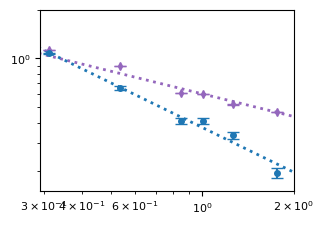

In [ ]:
from scipy.optimize import curve_fit
def fit(avg_num, b, a):
    return b * avg_num + a

log_x = np.log(n)
log_y = np.log(np.sqrt(np.array(1/np.array(result_max_var))))
# params, covariance = curve_fit(fit, log_x[1:], log_y[1:], p0=[1, -1, 0])
params, covariance = curve_fit(fit, log_x[1:], log_y[1:], p0=[1, -1])
op_b1, op_a1 = params
error_SCS = np.array(difference_SCS)
log_error_SCS = np.log(error_SCS)

log_y2 = np.log(np.sqrt(np.array(1/np.array(coh_max_var))))
params, covariance_sql = curve_fit(fit, log_x[1:], log_y2[1:], p0=[1, -1])
# params, covariance_sql = curve_fit(fit, log_x[1:], log_y2[1:], p0=[1, -1, 0])
op_b2, op_a2 = params
error_coh = np.array(difference_coh)
log_error_coh = np.log(error_coh)

cm = 0.393701
fig, ax = plt.subplots(figsize =(8.3*cm, 6*cm))

nx = np.linspace(0.1,2,10)
# plt.plot(nx, 1/(1*nx),'-',  color='teal', linewidth=0.5, label='HL')
# plt.plot(nx, 1/np.sqrt(1*nx),'-',color='saddlebrown', linewidth=0.5, label='SQL')
# plt.plot(nx, 1/(1*2*nx),'-', color='teal', linewidth=0.5, label='HL2')
# plt.plot(nx, 1/np.sqrt(1*2*nx),'-',color='saddlebrown', linewidth=0.5, label='SQL2')
# plt.plot(nx, 1/(1*4*nx),'-', color='teal', linewidth=0.5, label='HL3')
# plt.plot(nx, 1/np.sqrt(1*4*nx),'-',color='saddlebrown', linewidth=0.5, label='SQL3')

v = np.linspace(-1.3,2,100)

plt.plot(np.exp(v), np.exp(fit(v, op_b2, op_a2)), ':', linewidth=2, color='tab:purple', label='fit')
plt.plot(np.exp(v), np.exp(fit(v, op_b1, op_a1)), ':', linewidth=2, color='tab:blue',  label='fit')

# plt.plot(np.exp(log_x[2:]), np.exp(log_y2[2:]), color='tab:purple', linestyle='', markersize=4, marker='d', label='classical')
# plt.plot(np.exp(log_x[2:]), np.exp(log_y[2:]), color='tab:blue', linestyle='', markersize=4, marker='o', label='data')
plt.errorbar(np.exp(log_x[2:]), np.exp(log_y2[2:]),yerr=np.exp(log_error_coh[2:]), color='tab:purple', linestyle='', markersize=4, marker='d',capsize=4, label='classical')
plt.errorbar(np.exp(log_x[2:]), np.exp(log_y[2:]), yerr=np.exp(log_error_SCS[2:]), color='tab:blue', linestyle='', markersize=4, marker='o',capsize=4, label='data')




# Extract the diagonal elements of the covariance matrix as variances
var_op_b1, var_op_a1 = np.diag(covariance)
print(f"Variances: var_op_b1 = {var_op_b1}, var_op_a1 = {var_op_a1}")
var_op_b2, var_op_a2 = np.diag(covariance_sql)
print(f"Variances: var_op_b2 = {var_op_b2}, var_op_a2 = {var_op_a2}")

plt.xscale('log')
plt.yscale('log')
plt.xlim(np.exp(log_x[2])-0.02, 2)
plt.ylim([0.15, 2])


# plt.legend(fontsize=8)
print("Optimized Parameters:")
print("b:", op_b1)
print("a:", op_a1)
# print("c:", op_c1)
print('---------------')
print("Optimized Parameters:")
print("b:", op_b2)
print("a:", op_a2)
# print("c:", op_c2)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('fig3c.pdf')

In [ ]:
print(covariance)

[[0.0018669  0.0007967 ]
 [0.0007967  0.00146793]]


### gain

In [ ]:
A =  np.sqrt(1 / coh_max_var[-1])
B = np.sqrt(1 / result_max_var[-1])
ratio = 20 * np.log10(A / B)
print(ratio)

7.5078609560549046


### Error gain propragation $\\$
$gain=20log(\Delta\theta_{SQL}/\Delta\theta_{SCS})-> y=20[log10(a)-log10(b)]$ $\\$
error propragation equation: $\\$
$\Delta y = \sqrt{(\frac{\partial y}{\partial a})^2\Delta a^2 + (\frac{\partial y}{\partial b})^2\Delta b^2}$, therefore, we can get: $\\$
$\frac{\partial y}{\partial a}=20\frac{\partial log10(a)}{\partial a}=\frac{20}{ln(10)*a}$, $\frac{\partial y}{\partial b}=20\frac{\partial -log10(b)}{\partial b}=-\frac{20}{ln(10)*b}$ $\\$
$\Delta y = \sqrt{(\frac{20}{ln(10)*a})^2\Delta a^2 +(\frac{20}{ln(10)*b})^2\Delta b^2}$

In [ ]:
d_y = np.sqrt( (20/np.log(10)/np.exp(log_y2[-1]))**2 * difference_coh[-1]**2 + (20/np.log(10)/np.exp(log_y[-1]))**2 * difference_SCS[-1]**2)
print(d_y)

0.6330652634745653


In [ ]:
(20/np.log(10)/np.exp(log_y[-1]))**2 * difference_SCS[-1]**2

0.39991379125861143

In [ ]:
np.sqrt((20/np.log(10)/np.exp(log_y2[-1]))**2 * difference_coh[-1]**2)

0.029288847015703126

var_b, var_a, var_c: 0.09 0.01 0.04
var_b_sql, var_a_sql, var_c_sql: 0.06 0.01 0.04
Optimized Parameters:
b: 3.920491157144664
a: 1.7127728356345155
c: 0.1485577051532431
--------------
b_sql: 2.6190942005197217
a_sql: 0.9947677526116355
c_sql: 1.9901267595836912e-10
[0.06640117 0.16027106 0.31122967 0.53589801 0.84927936 1.00153571
 1.25897711 1.76159416]


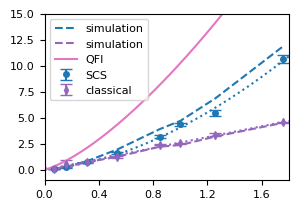

In [ ]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt


def fit(avg_num, b, a, c):
    return b * avg_num**a + c


def fit_sql(avg_num, k, c1):
    return k * avg_num + c1

# fig = make_figure(width=6, height=4, font_size=8)
# ax0 = fig.add_subplot(111)
cm = 0.393701
fig = plt.subplots(figsize =(8*cm, 5.5*cm))

# Assuming n and result_max are defined somewhere in your code
x_data = np.array(n)
y_data = np.array(result_max)
# y_sql = np.array([MEASURED_SQL[alpha] for alpha in alphas])
y_sql = np.array(coh_max)

# # Use curve_fit to find the parameters that minimize the difference
bounds = ([0, 1.5, 0 ],[5, 2.5, 1])
bounds_sql = ([0, 0.8, 0],[5, 1.2, 5])
p0 = [4, 2, 0.001]
po_sql = [0.5, 1, 0]
params, covariance = curve_fit(fit, x_data, y_data, bounds= bounds)
params_sql, covariance_sql = curve_fit(fit, x_data, y_sql, bounds=bounds_sql)


# Params now contains the optimized values for A, B, power1, power2, and c
op_b1, op_a1, op_c1 = params
op_b2, op_a2, op_c2 = params_sql

# Create a fitted curve using the optimized parameters
v = np.linspace(0, 1.8, 200)
y_fit = fit(v, op_b1, op_a1, op_c1)
y_sql_fit = fit(v, op_b2, op_a2, op_c2)

# Extract the diagonal elements of the covariance matrix as variances
var_b, var_a, var_c = np.diag(covariance)
var_b_sql, var_a_sql, var_c_sql = np.diag(covariance_sql)

print('var_b, var_a, var_c:', np.around(var_b,2), np.around(var_a,2), np.around(var_c,2))
print('var_b_sql, var_a_sql, var_c_sql:', np.around(var_b_sql,2), np.around(var_a_sql,2), np.around(var_c_sql,2))


# Plot the original data and the fitted curve
# ax0.scatter(x_data, y_data, color='tab:blue', marker='*', s=20, label=' SCS')
plt.errorbar(x_data, y_data, yerr=result_sigma,  linestyle='', color='tab:blue', markersize=4, marker='o', capsize=4, label='SCS')
plt.plot(v, y_fit, ':', color='tab:blue')

# ax0.scatter(x_data, y_sql,  color='tab:purple', marker='d', s=15, label='classical')
plt.errorbar(x_data, y_sql, yerr=coh_sigma, linestyle='', color='tab:purple', markersize=4, marker='d', capsize=4, label='classical')
plt.plot(v, y_sql_fit, ':', color='tab:purple')

plt.plot(n, result_sim_max, '--', color='tab:blue', label='simulation')
plt.plot(n, coh_sim_max, '--', color='tab:purple', label='simulation')

v = np.linspace(0, 4, 200)
plt.plot([compute_photon_number(w) for w in v], [compute_max_Fq(w) for w in v], color='tab:pink', label="QFI")
# ax0.plot(v,4*v+4*v**2,'k-')

# ax0.legend()
tick_start = 0
tick_end = 1.8
tick_step = 0.4
plt.xticks(np.arange(tick_start, tick_end, tick_step))
plt.xlim(0,1.8)
plt.ylim(-1,15)

# ax0.set_xlabel(r'Average photon number $\bar{N}$')
# ax0.set_ylabel('Fisher information')
plt.legend(loc='upper left', fontsize=8)

print("Optimized Parameters:")
print("b:", op_b1)
print("a:", op_a1)
print("c:", op_c1)
print('--------------')
print("b_sql:", op_b2)
print("a_sql:", op_a2)
print("c_sql:", op_c2)
plt.tick_params(axis='both', which='major', labelsize=8)
# plt.savefig('FI_vs_N_phase.pdf')
print(x_data)

In [ ]:
print(result_max)

[0.09443999394630286, 0.22833523972669173, 0.746084159421709, 1.6236188756181453, 3.2000465287275848, 4.361994416473713, 5.434768198464606, 10.635847112992117]


### 1/fisher information

Optimized Parameters:
b: 0.5198374750595856
a: -1.1004004151103777
c: -0.39663285483617666


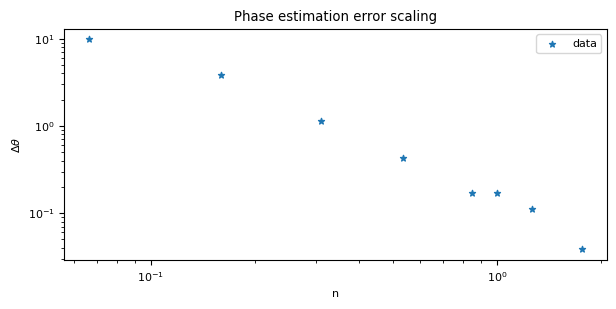

In [ ]:
from scipy.optimize import curve_fit

def fit(avg_num, b, a, c):
    return b * avg_num**a + c


params, covariance = curve_fit(fit, n, 1/np.array(result_max_var), p0=[1, -1, 0])
op_b1, op_a1, op_c1 = params


plt.figure(figsize=(7,3))
plt.scatter(n, 1/np.array(result_max_var), color='tab:blue', marker='*', s=20, label='data')



# v = np.linspace(0.05,1.75,100)
# plt.plot(v, fit(v, op_b1, op_a1, op_c1), color='tab:blue', label='fit')
# plt.plot(v, 1/v, label=r'$\frac{1}{n}$')
plt.xlabel(r'n')
plt.ylabel(r'$\Delta\theta$')
plt.title('Phase estimation error scaling')
plt.yscale('log')
plt.xscale('log')
# plt.ylabel(r'$\Delta\theta$')
plt.legend()

print("Optimized Parameters:")
print("b:", op_b1)
print("a:", op_a1)
print("c:", op_c1)

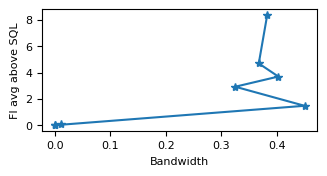

In [ ]:
fig = make_figure()
ax0 = fig.add_subplot(111)
ax0.plot(result_bandwidth, result_avg, '*-', color='tab:blue')
ax0.set_xlabel('Bandwidth')
ax0.set_ylabel('FI avg above SQL')
plt.savefig('FI_vs_bandwidth.pdf')

/var/folders/f5/st3433753w308xlm5y62ttnc0000gn/T/ipykernel_87471/3518501481.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(n, np.array(result_th_max) / np.array(result_bandwidth), '*-')


Text(0, 0.5, 'offset / bw')

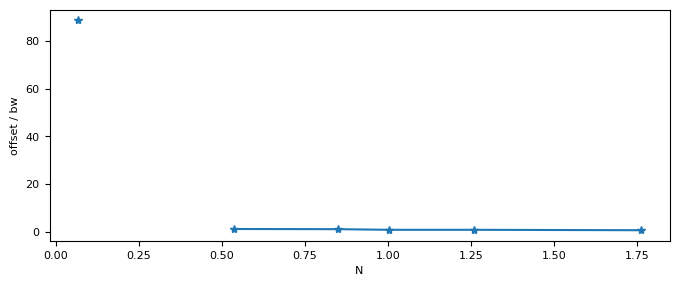

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(n, np.array(result_th_max) / np.array(result_bandwidth), '*-')
plt.xlabel('N')
plt.ylabel('offset / bw')

### Bandwidth and average

Optimized Parameters:
b: 3.7356545039696405
Power1: 1.4576930850135135
c: -0.21177988767360534


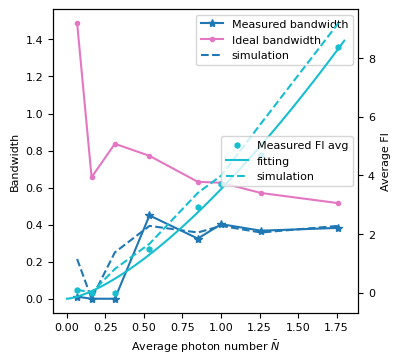

In [ ]:
fig = make_figure(width=10, height=10, font_size=8)
ax0 = fig.add_subplot(111)
ax1 = ax0.twinx()

# ** Average
# # Use curve_fit to find the parameters that minimize the difference
params, covariance = curve_fit(fit, n, result_avg, p0=[4, 2, 0], bounds=([0, 1.0, -0.5], [8, 2, 1]))
# Params now contains the optimized values for A, B, power1, power2, and c
op_b, op_a1, op_c1 = params
# Create a fitted curve using the optimized parameters
v = np.linspace(0, 1.8, 200)
y_fit = fit(v, op_b, op_a1, op_c1)
print("Optimized Parameters:")
print("b:", op_b)
print("Power1:", op_a1)
print("c:", op_c1)

ax1.scatter(n, result_avg, color='tab:cyan', marker='h', s=15, label="Measured FI avg")
ax1.plot(v, y_fit,  color='tab:cyan', label='fitting')

ax1.plot(n, result_sim_avg, '--', color='tab:cyan', label='simulation')

ax1.set_ylabel('Average FI')

# ** Bandwidth
ax0.plot(n, result_bandwidth, '*-', color='tab:blue', label="Measured bandwidth")
ax0.plot(n, result_ideal_bandwidth, '.-', color='tab:pink', label="Ideal bandwidth")

ax0.plot(n, result_sim_bandwidth, '--', color='tab:blue', label='simulation')

# ax0.title('Phase estimation with balanced cat states')
ax0.set_xlabel(r"Average photon number $\bar{N}$")
ax0.set_ylabel("Bandwidth")

ax0.legend()
ax1.legend(loc='right')

In [ ]:
alpha_data = {
    '0.5': load_experimental_data('pe/data/2023-11-13_alpha05.h5', THRESHOLDS['2023-11-13']),
    '0.75': load_experimental_data('pe/data/2023-11-14_alpha075.h5', THRESHOLDS['2023-11-14']),
    '1': load_experimental_data('pe/data/2023-11-13_alpha1.h5', THRESHOLDS['2023-11-13']),
    '1.25': load_experimental_data('pe/data/2023-11-14_alpha125.h5', THRESHOLDS['2023-11-14']),
    '1.5': load_experimental_data('pe/data/2023-11-13_alpha15.h5', THRESHOLDS['2023-11-13']),
    '1.6': load_experimental_data('pe/data/2023-11-13_alpha16.h5', THRESHOLDS['2023-11-13']),
    '1.75': load_experimental_data('pe/data/2023-11-14_alpha175.h5', THRESHOLDS['2023-11-14']),
    '2': load_experimental_data('pe/data/2023-11-13_alpha2.h5', THRESHOLDS['2023-11-13']),
}
n_boot=100
F_avg_error_SCS=[]
var_F_avg_list = []
for name in alpha_data:
    F_avg_array = []
    F_max_array = []
    data = alpha_data[name]
    x_len = len(data.x)
    mu_boot_g = np.zeros([n_boot, x_len])
    mu_boot_g_dp = np.zeros([n_boot, x_len])
    mu_boot_gvac = np.zeros([n_boot, x_len])
    mu_boot_gvac_dp = np.zeros([n_boot, x_len])
    sigma_tot = np.zeros(x_len)
    for i in range(x_len):
        # First measurement, g
        _, _, mu_boot_g[:,i] = bootstrap(data.m1[:, i], n_boot)

        # Second measurement, g vac
        _, _, mu_boot_gvac[:, i] = bootstrap(data.y_raw[:, i], n_boot)
    mu_g_g_vac_boot = (1-mu_boot_g) * (mu_boot_gvac) # shape = (100, 149)

    # scs 
    up_lim = 1.6
    x_dense = np.linspace(0, up_lim, 2000)
    # data fit
    for k in range(np.shape(mu_g_g_vac_boot)[0]):
        data_x = data.x
        data_y = mu_g_g_vac_boot[k,:]
        # fit
        data_fit = np.polyfit(data_x[data_x< up_lim], data_y[data_x < up_lim], POLYFIT_ORDER[name])
        y_fit = np.poly1d(data_fit)(x_dense)    
        m, a, _, _ = extract_FI_params(x_dense, y_fit, MEASURED_SQL[name])
        F_avg_array.append(a)
        F_max_array.append(m)

    var_F_avg_list.append(np.var(np.array(F_avg_array)))

F_avg_list_error = np.sqrt(np.array(var_F_avg_list))


2.7136645222399958
2.0000000000000004
0.3423271964765789


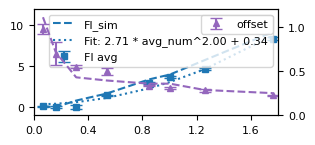

In [ ]:
cm = 0.393701
# fig, ax0 = plt.subplots(figsize =(3.5*cm, 3.5*cm))
fig, ax0 = plt.subplots(figsize =(8*cm, 3.5*cm))
# fig, ax0 = plt.subplots(figsize =(8*cm, 3.5*cm))
# ax0 = fig.add_subplot(111)
ax1 = ax0.twinx()

# FI avg
ax0.errorbar(n, result_avg, yerr=F_avg_list_error,color='tab:blue', linestyle='',marker='s', markersize=4,capsize=4, label="FI avg")
ax0.plot(n, result_sim_avg, '--', color='tab:blue', label='FI_sim')

ax0.set_xlim(0, 1.8)
ax0.set_ylim(-1,12)
tick_start = 0
tick_end = 1.8
tick_step = 0.4
ax0.set_xticks(np.arange(tick_start, tick_end, tick_step))


# Define the custom function
def fit_f_avg(avg_num, b, a, c):
    return b * avg_num**a + c

# Sample data
x_data = np.array(n)
y_data = np.array(result_avg)

# Use curve_fit to fit the data
lower_bounds = [2.7, 2, 0.33]
upper_bounds = [2.72, 2.1, 0.35]
params, covariance = curve_fit(fit_f_avg, x_data, y_data, bounds=(lower_bounds, upper_bounds))
b_fit, a_fit, c_fit = params
y_fit = fit_f_avg(x_data, b_fit, a_fit, c_fit)

var_b, var_a, var_c = np.diag(covariance)


# Plot the original data and the fitted curve
ax0.plot(x_data, y_fit, ':',label=f'Fit: {b_fit:.2f} * avg_num^{a_fit:.2f} + {c_fit:.2f}', color='tab:blue')
ax0.legend()

print(b_fit)
print(a_fit)
print(c_fit)

# t = np.linspace(0, 2, 100)
# f = 2.71*x_data**2+0.34
# ax0.plot(x_data, f)



#  offset
ax1.errorbar(n, result_th_max, yerr=offset_error_array, linestyle='', marker='^', markersize=4, color='tab:purple',capsize=4, label="offset")
ax1.plot(n, sim_th_max, '--', color='tab:purple')
ax1.set_ylim(0,1.2)
ax1.legend()
plt.savefig('fig3a.pdf')

In [ ]:
# print coefficients 
print('c1:', np.around(c1,3) )
print('c2:', np.around(c2,3) )
print('c3:', np.around(c3,3) )
print(result_avg)

NameError: name 'c1' is not defined

In [ ]:
print(f"Variance of b: {np.around(var_b,2)}")
print(f"Variance of a: {np.around(var_a,2)}")
print(f"Variance of c: {np.around(var_c,2)}")

Variance of b: 0.3
Variance of a: 0.11
Variance of c: 0.13


###  $\tilde{F}$ vs n fitting

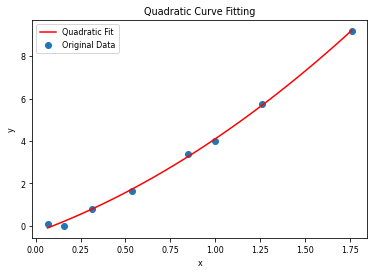

c1: 1.313
c2: 3.094
c3: -0.309


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Your data
x_data = n
y_data = result_sim_avg

# Define the quadratic function
def quadratic_curve(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the data to the quadratic curve
params, covariance = curve_fit(quadratic_curve, x_data, y_data)

# Extract the coefficients
c1, c2, c3 = params

# Generate points for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = quadratic_curve(x_fit, c1, c2, c3)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_fit, y_fit, color='red', label='Quadratic Fit')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Quadratic Curve Fitting')
plt.show()

# print coefficients 
print('c1:', np.around(c1,3) )
print('c2:', np.around(c2,3) )
print('c3:', np.around(c3,3) )



In [ ]:
offset_error_array

[0.05446514583070664,
 0.08240556001171823,
 0.017377529724760563,
 0.04109631086201171,
 0.010776356750873718,
 0.008878717023569372,
 0.013672211228422791,
 0.007754913281085714]

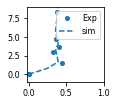

In [ ]:
# fig = make_figure(width=4, height=4, font_size=8)
# ax0 = fig.add_subplot(111)
cm = 0.393701
fig = plt.subplots(figsize =(3.5*cm, 3.5*cm))
plt.plot(result_bandwidth[1:], result_avg[1:], linestyle='', color='tab:blue', markersize=4, marker='o', label="Exp")
# plt.plot(result_bandwidth[:], result_avg[:], color='tab:blue', markersize=4, marker='o', label="Exp")

plt.plot(result_sim_bandwidth[1:], result_sim_avg[1:], '--', color='tab:blue', label='sim')
# ax0.plot(result_ideal_bandwidth, result_ideal_avg, '-', color='tab:pink', label='Ideal')
tick_start = 0
tick_end = 1.5
tick_step = 0.5
plt.xticks(np.arange(tick_start, tick_end, tick_step))

ax0.set_ylabel('Average FI')
ax0.set_xlabel(r'Bandwidth')
plt.ylim(-1,9)
# plt.xlim(0.3,1.7)
plt.legend(fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('phase_FI_vs_bandwidth.pdf')

### $\theta$ offset vs $n$

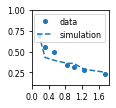

In [ ]:
# n vs theta_max
# fig = make_figure(width=4, height=4, font_size=8)
# ax0 = fig.add_subplot(111)
cm = 0.393701
fig = plt.subplots(figsize =(3.5*cm, 3.5*cm))

plt.plot(n[1:], result_th_max[1:], 'o', linestyle='', markersize=4, color='tab:blue', label='data')
# plt.plot(n[1:], result_th_max[1:], 'o', linestyle='', markersize=4, color='tab:blue', label='data')
plt.plot(n[1:], sim_th_max[1:], '--', color='tab:blue', label='simulation')
# ax0.set_xlabel(r'Average photon number $\bar{N}$')
# ax0.set_ylabel(r'$\theta$ offset')
tick_start = 0
tick_end = 1.8
tick_step = 0.4
plt.xticks(np.arange(tick_start, tick_end, tick_step))
plt.xlim(0,1.85)
plt.ylim(0.1,1)
plt.legend(fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('thetaoffset vs N.pdf')


## Unbalanced

### Same n

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

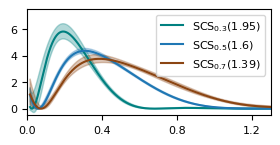

In [ ]:
n1_cat_data = {
    '0.3': load_experimental_data('pe/data/2023-11-14_03alpha195.h5', THRESHOLDS['2023-11-14']),
    # '0.4': load_experimental_data('pe/data/2023-11-14_04alpha1745.h5', THRESHOLDS['2023-11-14']),
    '0.5': load_experimental_data('pe/data/2023-11-13_alpha16.h5', THRESHOLDS['2023-11-13']),
    '0.7': load_experimental_data('pe/data/2023-11-14_07alpha139.h5', THRESHOLDS['2023-11-14']),
    # '0.6': load_experimental_data('pe/data/2023-11-14_06alpha149.h5', THRESHOLDS['2023-11-14']),

}

# fig = make_figure(width=4, height=4, font_size=8)
# ax0 = fig.add_subplot(111)
cm = 0.393701
# fig = plt.subplots(figsize =(3.5*cm, 3.5*cm))
fig = plt.subplots(figsize =(8*cm, 3.5*cm))

for alpha_coeff in list(n1_cat_data.keys()):
    data = n1_cat_data[alpha_coeff]
    pe = data.y
    phase = data.x

    # np.max(phase) if (np.max(phase) < 3) else 3
    up_lim = 1.6 if float(alpha) > 1 else np.max(data.x) - 0.1
    x = np.linspace(np.max([np.min(phase), 0.01]), up_lim, 2000)

    # if alpha_coeff == '0.3': order = 5
    # elif  alpha_coeff == '0.25': order = 6
    # else: order = 5
    if alpha_coeff == '0.25':
        order = 6
    elif alpha_coeff == '0.3':
        order = 6
        col = 'teal'#'tab:green'
    elif alpha_coeff == '0.4':
        order = 5
        col = 'tab:red'
    elif alpha_coeff == '0.5':
        order = 5
        col = 'tab:blue'
    elif alpha_coeff == '0.6':
        order = 5
    elif alpha_coeff == '0.7':
        order = 5
        col = 'saddlebrown'#'tab:orange'
    elif alpha_coeff == '0.8':
        order = 5
    else:
        order = 6
        col = 'black'

    # state_label = (
    #     txt_sqrt(np.round(1-float(alpha_coeff),1)) + txt_ket(0) + '+'
    #     + txt_sqrt(alpha_coeff) + txt_ket('\\alpha_{'+alpha_coeff+'}')
    # )
    state_label = name_scs(N1_ALPHA_MAP[alpha_coeff], alpha_coeff, omit05=False)
    data_fit = np.polyfit(phase[phase < up_lim], pe[phase < up_lim], order)
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])
    mu, sigma = compute_many_FI_error(data, x, order, up_lim, 100)

    plt.plot(x, FI_data, color=col, label=state_label)
    plt.fill_between(x, mu-sigma, mu+sigma, color=col, alpha=0.3)

tick_start = 0
tick_end = 1.3
tick_step = 0.4
plt.xticks(np.arange(tick_start, tick_end, tick_step))
plt.xlim([0, 1.3])
plt.ylim([-0.5, 7.5])
# ax0.set_xlabel("Phase [rad]")
# ax0.set_ylabel("Fisher information")
plt.legend(fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('fig4a.pdf')

### Same $\alpha$

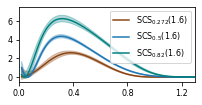

In [ ]:
unbalanced_alpha16_data = {
    # '0.119': load_experimental_data('pe/data/2023-11-15_0119alpha16.h5', THRESHOLDS['2023-11-14']),
    '0.272': load_experimental_data('pe/data/2023-11-18_0272alpha16.h5', THRESHOLDS['2023-11-14']),
    # '0.46': load_experimental_data('pe/data/2023-11-15_046alpha16.h5', THRESHOLDS['2023-11-14']),
    '0.5': load_experimental_data('pe/data/2023-11-13_alpha16.h5', THRESHOLDS['2023-11-13']),
    # '0.655': load_experimental_data('pe/data/2023-11-21_0655alpha16.h5', THRESHOLDS['2023-11-14']),
    '0.82': load_experimental_data('pe/data/2023-11-21_082alpha16.h5', THRESHOLDS['2023-11-14']),
}

SQL_ideal = 4*compute_photon_number(1.6)
SQL_measured = MEASURED_SQL['1.6']

# fig = make_figure(width=4, height=4, font_size=8)
# ax0 = fig.add_subplot(111)
colorset = {'0.5': 'tab:blue',
            '0.272': 'saddlebrown',
            '0.82': 'teal'}
cm = 0.393701
# fig = plt.subplots(figsize =(3.5*cm, 3.5*cm))
fig = plt.subplots(figsize =(8*cm, 3.5*cm))

for alpha_coeff in list(unbalanced_alpha16_data.keys()):
    data = unbalanced_alpha16_data[alpha_coeff]
    pe = data.y
    phase = data.x

    # if float(alpha) > 1 else np.max(data.x) - 0.1 #np.max(phase) if (np.max(phase) < 3) else 3
    up_lim = 1.6
    x = np.linspace(np.max([np.min(phase), 0.01]), up_lim, 2000)

    # if alpha_coeff == '0.3': order = 5
    # elif  alpha_coeff == '0.25': order = 6
    # else: order = 5
    if alpha_coeff == '0.119':
        order = 6
    elif alpha_coeff == '0.272':
        order = 6
        col = 'saddlebrown' #'tab:orange'
    elif alpha_coeff == '0.46':
        order = POLYFIT_ORDER['1.6']
    elif alpha_coeff == '0.5':
        order = POLYFIT_ORDER['1.6']
        col = 'tab:blue'
    elif alpha_coeff == '0.655':
        order = 5
    elif alpha_coeff == '0.82':
        order = 5
        col = 'teal'#'tab:green'
    else:
        order = 6

    data_fit = np.polyfit(phase[phase < up_lim], pe[phase < up_lim], order)
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])
    mu, sigma = compute_many_FI_error(data, x, order, up_lim, 100)

    # Label state (1-x)|0> + x|alpha>
    # state_label = (
    #     txt_sqrt(np.round(1-float(alpha_coeff), 3)) + txt_ket(0) + '+'
    #     + txt_sqrt(alpha_coeff) + txt_ket('\\alpha = 1.6')
    # )
    state_label = name_scs(1.6, alpha_coeff, omit05=False)
    # Add to plot
    plt.plot(x, FI_data, color=col,label=state_label)
    plt.fill_between(x, mu-sigma, mu+sigma, color=col, alpha=0.3)

# ax2.axhline(y=SQL_measured, color='orange', label='Measured SQL')
# ax2.axhline(y=SQL_ideal, color='red', label='Ideal SQL')
tick_start = 0
tick_end = 1.3
tick_step = 0.4
plt.xticks(np.arange(tick_start, tick_end, tick_step))
plt.xlim([0, 1.3])
plt.ylim([-0.5, 7.5])
# ax0.set_xlabel("Phase [rad]")
# ax0.set_ylabel("Fisher information")
plt.legend(fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('fig4b.pdf')

# Fig 2 pannel 2

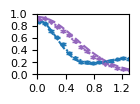

In [ ]:
data_list = {
    'SCS': load_experimental_data('pe/data/2023-11-13_alpha2.h5', THRESHOLDS['2023-11-13'], pre_selection=True),
    'SQL': load_experimental_data('pe/data/2023-11-13_c2.h5', THRESHOLDS['2023-11-13'], pre_selection=True),
}


sim_dir = {
    "SCS": np.load('pe/sim/0_plus_alpha2_all.npz', 'r'),
    "SQL": np.load('pe/sim/alpha1327_all.npz', 'r'),
}

cm = 0.393701
fig = plt.subplots(figsize =(3*cm, 2*cm))
# fig = plt.subplots(figsize =(8*cm, 5.5*cm))
# ax0 = fig.add_subplot(111)
n_boot = 100
colors = {
    'SCS': ['tab:blue', 'o'],
    'SQL': ['tab:purple', 'd'],
}
for name in data_list:
    data = data_list[name]
    x_len = len(data.x)
    mu_boot_g = np.zeros([n_boot, x_len])
    mu_boot_gvac = np.zeros([n_boot, x_len])
    sigma_tot = np.zeros(x_len)

    # exp data
    exp_data = data_list[name]
    phase = exp_data.x
    mx_g_avg = exp_data.y
    data_fit = np.polyfit(phase[phase<up_lim], mx_g_avg[phase<up_lim], POLYFIT_ORDER[str(alpha)])
    

    # sim data
    sim_data = sim_dir[name]
    phase_sim = sim_data['x']
    pe_sim = sim_data['probability_sim']

    for i in range(x_len):
        # First measurement, g
        _, _, mu_boot_g[:,i] = bootstrap(data.m1[:, i], n_boot)

        # Second measurement, g vac
        _, _, mu_boot_gvac[:, i] = bootstrap(data.y_raw[:, i], n_boot)

        # Find variance
        mu_boot_e = 1-mu_boot_g[:, i]
        cov1 = np.cov(mu_boot_e, mu_boot_gvac[:, i])[0, 1]
        cov2 = np.cov(mu_boot_e**2, mu_boot_gvac[:, i]**2)[0, 1]
        sigma_tot[i] = np.sqrt(
            cov2 + np.mean(mu_boot_e**2)*np.mean(mu_boot_gvac[:, i]**2) -
            (cov1+np.mean(mu_boot_e)*np.mean(mu_boot_gvac[:, i]))**2
        )

    mu = np.mean(1-mu_boot_g, 0) * np.mean(mu_boot_gvac, 0)
    # Add plots
    if colors[name]:
        col = colors[name]
    else:
        col = [None, None]
    if name[0] == 'c': lab = txt_ket(fr'\alpha={str(COH_MAP[file[1:]])}') #'classical'
    else: lab = f'SCS({name})'  #txt_ket(0) + '+' + txt_ket(fr"\alpha = {name}")


    # ax0.errorbar(data.x, mu, yerr=sigma_tot, fmt='.', capsize=3, ecolor='black')
    plt.plot(phase_sim, pe_sim, '--',color=col[0],label='sim'+f'{name}')
    
    plt.errorbar(data.x[::5], data.y[::5], yerr=sigma_tot[::5],  markersize=2, linestyle='', color=col[0], marker=col[1], capsize=2, label = 'exp' + f'{name}')
    # ax0.plot(data.x, data.y, '*', color=col[0], markersize = 5,label = 'exp' + f'{name}')
    # ax0.fill_between(data.x, mu-sigma_tot, mu+sigma_tot, color=col[0], alpha=0.3)
    
    plt.plot(x, np.poly1d(data_fit)(x), linestyle=':', color=col[0],label = 'fit' + f'{name}')

    # plt.legend(fontsize='8')
    plt.xticks(np.arange(0, 1.3, 0.4))
    plt.yticks(np.arange(0, 1.1, 0.2))
    plt.ylim(0, 1)
    plt.xlim([0, 1.3])
    plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('Fig2b.pdf')
plt.show()


### unbalanced cat--max F and bandwidth versus weights

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

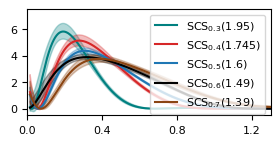

In [ ]:
n1_cat_data = {
    '0.3': load_experimental_data('pe/data/2023-11-14_03alpha195.h5', THRESHOLDS['2023-11-14']),
    '0.4': load_experimental_data('pe/data/2023-11-14_04alpha1745.h5', THRESHOLDS['2023-11-14']),
    '0.5': load_experimental_data('pe/data/2023-11-13_alpha16.h5', THRESHOLDS['2023-11-13']),
    '0.6': load_experimental_data('pe/data/2023-11-14_06alpha149_copy.h5', THRESHOLDS['2023-11-14']),
    '0.7': load_experimental_data('pe/data/2023-11-14_07alpha139.h5', THRESHOLDS['2023-11-14']),

}


# max value of Fisher information
result_max = []
result_bandwidth = []
result_sigma = []

cm = 0.393701
fig = plt.subplots(figsize =(8*cm, 3.5*cm))

for alpha_coeff in list(n1_cat_data.keys()):
    data = n1_cat_data[alpha_coeff]
    pe = data.y
    phase = data.x

    # np.max(phase) if (np.max(phase) < 3) else 3
    up_lim = 1.6 if float(alpha) > 1 else np.max(data.x) - 0.1
    x = np.linspace(np.max([np.min(phase), 0.01]), up_lim, 2000)

 
    if alpha_coeff == '0.3':
        order = 6 #7 #6
        col = 'teal'
    elif alpha_coeff == '0.4':
        order = 5 
        col = 'tab:red'
    elif alpha_coeff == '0.5':
        order = 5
        col = 'tab:blue'
    elif alpha_coeff == '0.6':
        order = 4
        col = 'black'
    elif alpha_coeff == '0.7':
        order = 5
        col = 'saddlebrown'


    state_label = name_scs(N1_ALPHA_MAP[alpha_coeff], alpha_coeff, omit05=False)
    data_fit = np.polyfit(phase[phase < up_lim], pe[phase < up_lim], order)
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])
    mu, sigma = compute_many_FI_error(data, x, order, up_lim, 100)

    plt.plot(x, FI_data, color=col, label=state_label)
    plt.fill_between(x, mu-sigma, mu+sigma, color=col, alpha=0.3)

    m, a, b, mx = extract_FI_params(x, y_fit, 0.976)
    result_max.append(m)
    result_bandwidth.append(b)
    result_sigma.append(sigma[np.argmax(FI_data)])

    

tick_start = 0
tick_end = 1.3
tick_step = 0.4
plt.xticks(np.arange(tick_start, tick_end, tick_step))
plt.xlim([0, 1.3])
plt.ylim([-0.5, 7.5])
# ax0.set_xlabel("Phase [rad]")
# ax0.set_ylabel("Fisher information")
plt.legend(fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
# plt.savefig('fig4a.pdf')

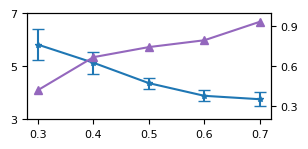

In [ ]:




cm = 0.393701
weights = np.array([0.3, 0.4, 0.5, 0.6, 0.7])
fig, ax0 = plt.subplots(figsize =(8*cm, 3.5*cm))

ax0.errorbar(weights, result_max, yerr=result_sigma, color='tab:blue', linestyle = '-', marker = '*', markersize=4,capsize=4, )
ax0.set_yticks([3, 5, 7])
ax0.set_ylim(3,7)

ax1 = ax0.twinx()
ax1.plot(weights, result_bandwidth, color='tab:purple', linestyle = '-', marker = '^')
ax1.set_ylim(0.2,1)
ax1.set_yticks([0.3, 0.6, 0.9])
plt.savefig('fig4e.pdf')

### Max FI of dense simulation of $SCS_{w}$

In [ ]:
SCS_diff_weights_sim = { }

additional_weights = [round(i, 2) for i in np.linspace(0.3, 0.7, 21)]

for weight in additional_weights:
    SCS_diff_weights_sim[str(weight)] = f'pe/sim/SCS_different_weight/{weight}_all.npz'

print(SCS_diff_weights_sim)


{'0.3': 'pe/sim/SCS_different_weight/0.3_all.npz', '0.32': 'pe/sim/SCS_different_weight/0.32_all.npz', '0.34': 'pe/sim/SCS_different_weight/0.34_all.npz', '0.36': 'pe/sim/SCS_different_weight/0.36_all.npz', '0.38': 'pe/sim/SCS_different_weight/0.38_all.npz', '0.4': 'pe/sim/SCS_different_weight/0.4_all.npz', '0.42': 'pe/sim/SCS_different_weight/0.42_all.npz', '0.44': 'pe/sim/SCS_different_weight/0.44_all.npz', '0.46': 'pe/sim/SCS_different_weight/0.46_all.npz', '0.48': 'pe/sim/SCS_different_weight/0.48_all.npz', '0.5': 'pe/sim/SCS_different_weight/0.5_all.npz', '0.52': 'pe/sim/SCS_different_weight/0.52_all.npz', '0.54': 'pe/sim/SCS_different_weight/0.54_all.npz', '0.56': 'pe/sim/SCS_different_weight/0.56_all.npz', '0.58': 'pe/sim/SCS_different_weight/0.58_all.npz', '0.6': 'pe/sim/SCS_different_weight/0.6_all.npz', '0.62': 'pe/sim/SCS_different_weight/0.62_all.npz', '0.64': 'pe/sim/SCS_different_weight/0.64_all.npz', '0.66': 'pe/sim/SCS_different_weight/0.66_all.npz', '0.68': 'pe/sim/SCS

In [ ]:
def extract_FI_params(x, y, SQL):
    x = np.array(x, dtype='float')
    y = np.array(y)

    FI = compute_FI(y, x[1] - x[0])
    x = x[FI < np.inf][1::]
    FI = FI[FI < np.inf][1::]

    # Extract parameters
    result_max = np.max(FI)
    idx = (FI > SQL) & (x >= 0)
    if (np.sum(idx) > 0):
        value = FI[idx]
        result_avg = np.mean(value)
        result_bandwidth = x[idx][-1] - x[idx][0]
        max_x = x[np.argmax(FI)]
    else:
        result_avg = 0
        result_bandwidth = 0
        max_x = x[np.argmax(FI)]
    return result_max, result_avg, result_bandwidth, max_x

[6.475463227423811, 6.287074317257874, 5.76145633329172, 5.632703390859316, 5.553478873133286, 5.369102350293154, 5.577045361623181, 5.023212861894736, 4.884601957197807, 4.7537714514643605, 4.834688254518306, 5.32369119787284, 4.585655384324651, 4.547363408237281, 4.346509347151827, 4.26938225120605, 4.194667504713609, 3.912027141336506, 4.244136296981024, 3.8439656556575637, 4.0685212340633115]
[0.5364583615269931, 0.5364583615269931, 0.5364583615269931, 0.5722222522954593, 0.5722222522954593, 0.6079861430639255, 0.6437500338323917, 0.6437500338323917, 0.6437500338323917, 0.6437500338323917, 0.6795139246008579, 0.7152778153693241, 0.6795139246008579, 0.7152778153693241, 0.7510417061377903, 0.7152778153693241, 0.7510417061377904, 0.7510417061377904, 0.7868055969062566, 0.7868055969062566, 0.8225694876747228]


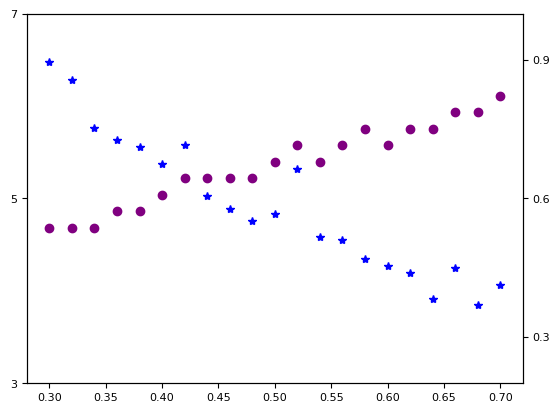

In [ ]:
SCS_diff_weights_sim = { }

weights_sim = np.linspace(0.3, 0.7, 21)
additional_weights = [round(i, 2) for i in np.linspace(0.3, 0.7, 21)]

for weight in additional_weights:
    SCS_diff_weights_sim[str(weight)] = f'pe/sim/SCS_different_weight/{weight}_all.npz'


# SCS exp_sim data
result_sim_max = []
result_sim_avg = []
result_sim_bandwidth = []
sim_th_max = []



cm = 0.393701
# fig = plt.subplots(figsize =(8*cm, 3.5*cm))

for alpha in list(SCS_diff_weights_sim.keys()):
    
    sim = np.load(SCS_diff_weights_sim[alpha], 'r')
    phase_sim = sim['x']
    pe_sim = sim['probability_sim']
    x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
    y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]

    # m, a, b, mx = extract_FI_params(x_sim, y_sim, 0.976)
    m, a, b, mx = extract_FI_params(x_sim, y_sim, 0.734602921792313) #0.734602921792313 is SQL of coherent(1)
    result_sim_max.append(m)
    result_sim_avg.append(a)
    result_sim_bandwidth.append(b)
    sim_th_max.append(mx)

print(result_sim_max)
print(result_sim_bandwidth)

fig, ax0 = plt.subplots()
ax0.plot(weights_sim, result_sim_max, '*', color='blue')
ax0.set_yticks([3, 5, 7])
ax0.set_ylim(3,7)

ax1 = ax0.twinx()
ax1.plot(weights_sim, result_sim_bandwidth, 'o', color='purple')
ax1.set_ylim(0.2,1)
ax1.set_yticks([0.3, 0.6, 0.9])



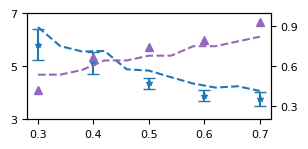

In [ ]:
fig, ax0 = plt.subplots(figsize =(8*cm, 3.5*cm))

ax0.errorbar(weights, result_max, yerr=result_sigma, color='tab:blue', linestyle = '', marker = '*', markersize=4,capsize=4, )
# ax0.plot(weights_sim, result_sim_max, '-.', color='tab:blue')
ax0.plot(weights_sim[::2], result_sim_max[::2], '--', color='tab:blue')
ax0.set_yticks([3, 5, 7])
ax0.set_ylim(3,7)

ax1 = ax0.twinx()
ax1.plot(weights, result_bandwidth, color='tab:purple', linestyle = '', marker = '^')
# ax1.plot(weights_sim, result_sim_bandwidth, '-.', color='tab:purple', markersize = 2)
ax1.plot(weights_sim[::2], result_sim_bandwidth[::2], '--', color='tab:purple', markersize = 4)
ax1.set_ylim(0.2,1)
ax1.set_yticks([0.3, 0.6, 0.9])
plt.savefig('fig4e.pdf')


In [ ]:
np.shape(weights_sim[::2])

(11,)

### FI enhancement compared between one probablility and four probability

[0.07263708 0.12744703 0.08919369 0.22754654 0.61957235 0.3573793
 0.45805494 0.1854463 ]


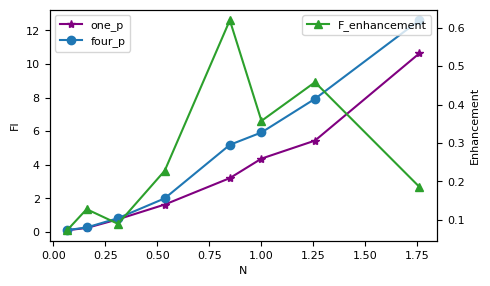

In [ ]:
one_p = np.array([0.09443999394630286, 0.22833523972669173, 0.746084159421709, 1.6236188756181453, 3.2000465287275848, 4.361994416473713, 5.434768198464606, 10.635847112992117])
four_p = np.array([0.1012998389617821, 0.25743588866029343, 0.8126301573350792, 1.9930677278252031, 5.182706890964161, 5.92088094731947, 7.924190606305562, 12.608225584371592])

fig, ax1 = plt.subplots(figsize = (5,3))
ax1.plot(x_data, one_p, '*-', color = 'purple', label = 'one_p')
ax1.plot(x_data, four_p, 'o-', color = 'tab:blue', label = 'four_p')
ax1.set_ylabel('FI')
ax1.set_xlabel('N')
ax1.legend()
ax2 = ax1.twinx()
enh = (four_p-one_p) / one_p
ax2.plot(x_data, enh, '^-', color = 'tab:green', label='F_enhancement')
# ax2.set_ylim(0,3)
ax2.set_ylabel('Enhancement')
ax2.legend()

print(enh)



### simulate various unbalanced SCS states

In [ ]:
def compute_photon_number(alpha):
    cdim = 30
    psi = (coherent(cdim, 0) + coherent(cdim, alpha)).unit()
    a = destroy(cdim)
    return np.abs(np.array(psi.dag() * a.dag()*a * psi))

def compute_photon_number_unbalanced_SCS(w, alpha):
    cdim = 30
    psi = (np.sqrt(1-w) * coherent(cdim, 0) + np.sqrt(w) * coherent(cdim, alpha)).unit()
    a = destroy(cdim)
    return np.abs(np.array(psi.dag() * a.dag()*a * psi))

print('w=0.3:', np.around( compute_photon_number_unbalanced_SCS(0.3, 1.95),3 ) )
print('w=0.4:', np.around( compute_photon_number_unbalanced_SCS(0.4, 1.745),3 ) )
print('w=0.5:', np.around( compute_photon_number_unbalanced_SCS(0.5, 1.60),3 ) )
print('w=0.6:', np.around( compute_photon_number_unbalanced_SCS(0.6, 1.49),3 ) )
print('w=0.7:', np.around( compute_photon_number_unbalanced_SCS(0.7, 1.39),3 ) )
print('w=0.8:', np.around( compute_photon_number_unbalanced_SCS(0.8, 1.3),3 ) )



w=0.3: 1.003
w=0.4: 1.004
w=0.5: 1.002
w=0.6: 1.007
w=0.7: 1.003
w=0.8: 1.006


In [ ]:
compute_photon_number(1.6)

1.0015357138215844

In [ ]:
import numpy as np
from qutip import coherent, destroy

def compute_alpha_SCS(w_list, avg_N=1):
    cdim = 30
    a = destroy(cdim)
    
    results = []
    
    for w in w_list:
        alpha = 0.0
        step = 0.005
        max_alpha  = 2
        
        while alpha <= max_alpha:
            psi = (np.sqrt(1-w) * coherent(cdim, 0) + np.sqrt(w) * coherent(cdim, alpha)).unit()  
            size = np.abs(np.array(psi.dag() * a.dag() * a * psi))
            
            if np.isclose(size, avg_N, atol=0.005):
                results.append( (np.around(1-w, 3), np.around(w, 3), np.around(alpha,6)) )
                break
            
            alpha += step
            
        if alpha > max_alpha: # # If no valid alpha was found within the max_alpha limit, do not append anything
            results.append((w, None))
        
    return np.array(results)


# Example usage:
w_list = np.linspace(0.3, 0.7, 21)
alpha_values = compute_alpha_SCS(w_list)
print(alpha_values)

np.savez('/Users/panxiaozhou/Documents/GitHub/Grape/grape/SCS_weight_fixedN/w_and_alpha_with_fixed_N', weight_0 = alpha_values[:,0], weight_alpha = alpha_values[:,1], alpha = alpha_values[:,2])


[[0.7   0.3   1.945]
 [0.68  0.32  1.895]
 [0.66  0.34  1.855]
 [0.64  0.36  1.815]
 [0.62  0.38  1.775]
 [0.6   0.4   1.74 ]
 [0.58  0.42  1.71 ]
 [0.56  0.44  1.68 ]
 [0.54  0.46  1.65 ]
 [0.52  0.48  1.625]
 [0.5   0.5   1.6  ]
 [0.48  0.52  1.575]
 [0.46  0.54  1.55 ]
 [0.44  0.56  1.53 ]
 [0.42  0.58  1.505]
 [0.4   0.6   1.485]
 [0.38  0.62  1.465]
 [0.36  0.64  1.445]
 [0.34  0.66  1.425]
 [0.32  0.68  1.405]
 [0.3   0.7   1.39 ]]


In [ ]:
np.savez('/Users/panxiaozhou/Documents/GitHub/Grape/grape/SCS_weight_fixedN/w_and_alpha_with_fixed_N', weight = alpha_values[:,0], alpha = alpha_values[:,1])

In [ ]:
import numpy as np

def delta_theta_coh(n):
    return 1 / np.sqrt(4 * n)

def delta_theta_SCS(n):
    nom = 0.626
    return 1 / np.sqrt(  4*( (1-nom**2) / nom**2 )*n**2+4*n )

# def delta_theta_SCS(n):
#     return 1 / np.sqrt(4 * n**2 +4 * n)

gain = 20 * np.log10(  delta_theta_coh(1.76) / delta_theta_SCS(1.76)  )

print(gain)


amp_gain = 20 * np.log10( (8 * 1.76 + 4) / 4)
print(amp_gain)

### old analysis of  error budge 

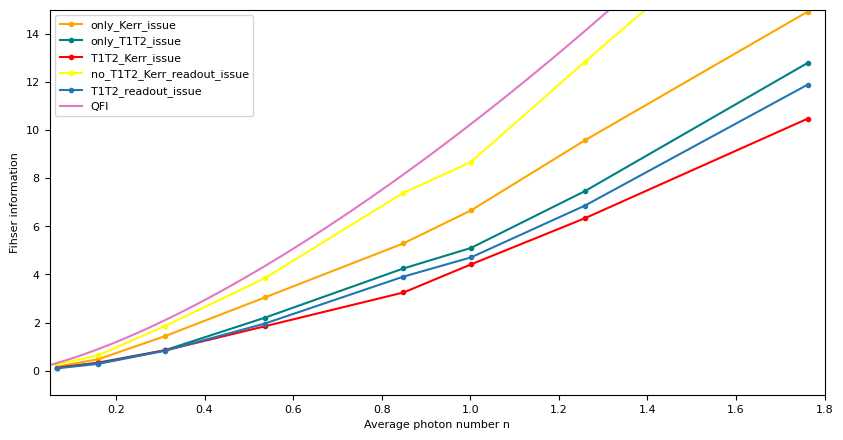

In [11]:
alpha_sim_only_Kerr = {
    '0.5': 'pe/sim/SCS_only_Kerr/0_plus_alpha05_none.npz',
    '0.75': 'pe/sim/SCS_only_Kerr/0_plus_alpha075_none.npz',
    '1': 'pe/sim/SCS_only_Kerr/0_plus_alpha1_none.npz',
    '1.25': 'pe/sim/SCS_only_Kerr/0_plus_alpha125_none.npz',
    '1.5': 'pe/sim/SCS_only_Kerr/0_plus_alpha15_none.npz',
    '1.6': 'pe/sim/SCS_only_Kerr/0_plus_alpha16_none.npz',
    '1.75': 'pe/sim/SCS_only_Kerr/0_plus_alpha175_none.npz',
    '2': 'pe/sim/SCS_only_Kerr/0_plus_alpha2_none.npz',
}
alpha_sim_only_measure = {
    '0.5': 'pe/sim/SCS_only_measure/0_plus_alpha05_impm.npz',
    '0.75': 'pe/sim/SCS_only_measure/0_plus_alpha075_impm.npz',
    '1': 'pe/sim/SCS_only_measure/0_plus_alpha1_impm.npz',
    '1.25': 'pe/sim/SCS_only_measure/0_plus_alpha125_impm.npz',
    '1.5': 'pe/sim/SCS_only_measure/0_plus_alpha15_impm.npz',
    '1.6': 'pe/sim/SCS_only_measure/0_plus_alpha16_impm.npz',
    '1.75': 'pe/sim/SCS_only_measure/0_plus_alpha175_impm.npz',
    '2': 'pe/sim/SCS_only_measure/0_plus_alpha2_impm.npz',
}
alpha_sim_only_T1T2 = {
    '0.5': 'pe/sim/SCS_only_T1T2/0_plus_alpha05_all.npz',
    '0.75': 'pe/sim/SCS_only_T1T2/0_plus_alpha075_all.npz',
    '1': 'pe/sim/SCS_only_T1T2/0_plus_alpha1_all.npz',
    '1.25': 'pe/sim/SCS_only_T1T2/0_plus_alpha125_all.npz',
    '1.5': 'pe/sim/SCS_only_T1T2/0_plus_alpha15_all.npz',
    '1.6': 'pe/sim/SCS_only_T1T2/0_plus_alpha16_all.npz',
    '1.75': 'pe/sim/SCS_only_T1T2/0_plus_alpha175_all.npz',
    '2': 'pe/sim/SCS_only_T1T2/0_plus_alpha2_all.npz',
}
alpha_sim_T1T2_Kerr = {
    '0.5': 'pe/sim/SCS_T1T2_Kerr/0_plus_alpha05_nk.npz',
    '0.75': 'pe/sim/SCS_T1T2_Kerr/0_plus_alpha075_nk.npz',
    '1': 'pe/sim/SCS_T1T2_Kerr/0_plus_alpha1_nk.npz',
    '1.25': 'pe/sim/SCS_T1T2_Kerr/0_plus_alpha125_nk.npz',
    '1.5': 'pe/sim/SCS_T1T2_Kerr/0_plus_alpha15_nk.npz',
    '1.6': 'pe/sim/SCS_T1T2_Kerr/0_plus_alpha16_nk.npz',
    '1.75': 'pe/sim/SCS_T1T2_Kerr/0_plus_alpha175_nk.npz',
    '2': 'pe/sim/SCS_T1T2_Kerr/0_plus_alpha2_nk.npz',
}
alpha_sim_no_T1T2_Kerr = {
    '0.5': 'pe/sim/SCS_no_T1T2_Kerr/0_plus_alpha05_ok.npz',
    '0.75': 'pe/sim/SCS_no_T1T2_Kerr/0_plus_alpha075_ok.npz',
    '1': 'pe/sim/SCS_no_T1T2_Kerr/0_plus_alpha1_ok.npz',
    '1.25': 'pe/sim/SCS_no_T1T2_Kerr/0_plus_alpha125_ok.npz',
    '1.5': 'pe/sim/SCS_no_T1T2_Kerr/0_plus_alpha15_ok.npz',
    '1.6': 'pe/sim/SCS_no_T1T2_Kerr/0_plus_alpha16_ok.npz',
    '1.75': 'pe/sim/SCS_no_T1T2_Kerr/0_plus_alpha175_ok.npz',
    '2': 'pe/sim/SCS_no_T1T2_Kerr/0_plus_alpha2_ok.npz',
}

# SCS exp_sim error budge

result_sim_max_only_Kerr = []
result_sim_avg_only_Kerr = []
result_sim_bandwidth_only_Kerr = []
sim_th_max_only_Kerr = []

result_sim_max_only_measure = []
result_sim_avg_only_measure = []
result_sim_bandwidth_only_measure = []
sim_th_max_only_measure = []

result_sim_max_only_T1T2 = []
result_sim_avg_only_T1T2 = []
result_sim_bandwidth_only_T1T2 = []
sim_th_max_only_T1T2 = []

result_sim_max_T1T2_Kerr = []
result_sim_avg_T1T2_Kerr = []
result_sim_bandwidth_T1T2_Kerr = []
sim_th_max_T1T2_Kerr = []

result_sim_max_no_T1T2_Kerr = []
result_sim_avg_no_T1T2_Kerr = []
result_sim_bandwidth_no_T1T2_Kerr = []
sim_th_max_no_T1T2_Kerr = []


ax0, fig = plt.subplots(figsize=(10,5))

for alpha in alpha_data:
    # np.max(data.x) - 0.1 if (np.max(data.x) < 3) else 3
    up_lim = 1.6 if float(alpha) > 1 else np.max(data.x) - 0.1
    x_dense = np.linspace(min(theta_list), up_lim, 2000)

    # simulation: only Kerr
    if 1:
        # print('only kerr')
        sim = np.load(alpha_sim_only_Kerr[alpha], 'r')
        # print(alpha)
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        result_sim_max_only_Kerr.append(m)
        result_sim_avg_only_Kerr.append(a)
        result_sim_bandwidth_only_Kerr.append(b)
        sim_th_max_only_Kerr.append(mx)

    # simulation: only measure
    if 1:
        sim = np.load(alpha_sim_only_measure[alpha], 'r')
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        result_sim_max_only_measure.append(m)
        result_sim_avg_only_measure.append(a)
        result_sim_bandwidth_only_measure.append(b)
        sim_th_max_only_measure.append(mx)

    # simulation: only T1 T2
    if 1:
        sim = np.load(alpha_sim_only_T1T2[alpha], 'r')
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        result_sim_max_only_T1T2.append(m)
        result_sim_avg_only_T1T2.append(a)
        result_sim_bandwidth_only_T1T2.append(b)
        sim_th_max_only_T1T2.append(mx)

    # simulation: T1 T2 Kerr
    if 1:
        sim = np.load(alpha_sim_T1T2_Kerr[alpha], 'r')
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        result_sim_max_T1T2_Kerr.append(m)
        result_sim_avg_T1T2_Kerr.append(a)
        result_sim_bandwidth_T1T2_Kerr.append(b)
        sim_th_max_T1T2_Kerr.append(mx)
    
    # simulation: no T1 T2 Kerr
    if 1:
        sim = np.load(alpha_sim_no_T1T2_Kerr[alpha], 'r')
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        result_sim_max_no_T1T2_Kerr.append(m)
        result_sim_avg_no_T1T2_Kerr.append(a)
        result_sim_bandwidth_no_T1T2_Kerr.append(b)
        sim_th_max_no_T1T2_Kerr.append(mx)
    

n = [compute_photon_number(v) for v in np_alphas]
v = np.linspace(0,2,200)

# Fisher information plot

plt.plot(n, result_sim_max_only_Kerr, '.-', color='orange', label="only_Kerr_issue")
# plt.plot(n, result_sim_max_only_measure, '-.', color='brown', label="only measure")
plt.plot(n, result_sim_max_only_T1T2, '.-', color='teal', label="only_T1T2_issue")
plt.plot(n, result_sim_max_T1T2_Kerr, '.-', color='red', label="T1T2_Kerr_issue")
plt.plot(n, result_sim_max_no_T1T2_Kerr, '.-', color='yellow', label="no_T1T2_Kerr_readout_issue")


# plt.errorbar(x_data, y_data, yerr=result_sigma,  linestyle='', color='tab:blue', markersize=4, marker='o', capsize=4, label='SCS')
# plt.plot(v, y_fit, ':', color='tab:blue')
# plt.errorbar(x_data, y_sql, yerr=coh_sigma, linestyle='', color='tab:purple', markersize=4, marker='d', capsize=4, label='classical')
# plt.plot(v, y_sql_fit, ':', color='tab:purple')
plt.plot(n, result_sim_max, '.-', color='tab:blue', label='T1T2_readout_issue')
# plt.plot(n, coh_sim_max, '--', color='tab:purple', label='simulation')


v = np.linspace(0, 4, 200)
plt.plot([compute_photon_number(w) for w in v], [compute_max_Fq(w) for w in v], color='tab:pink', label="QFI")

plt.xlabel(r"Average photon number n")
plt.ylabel("Fihser information")
plt.legend()
plt.xlim(0.05,1.8)
plt.ylim(-1, 15)
plt.show()



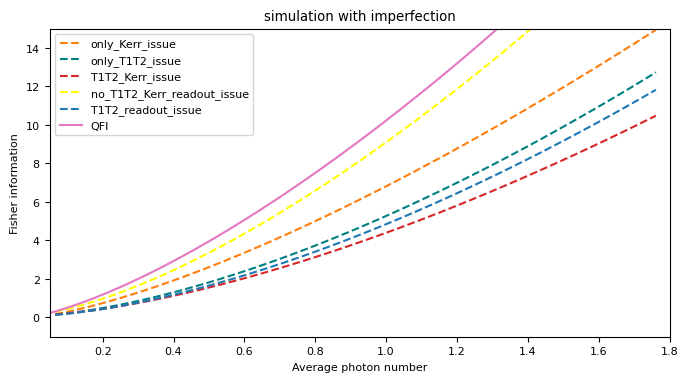

In [9]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Provided x values and multiple sets of y values
x_data = np.array([0.06640117167171947, 0.16027105821023155, 0.311229665600927, 0.5358980117251503,
                   0.8492793602260809, 1.0015357138215844, 1.258977106111736, 1.761594155955764])

# Multiple sets of y values

y_datasets = [
    result_sim_max_only_Kerr,
    result_sim_max_only_T1T2,
    result_sim_max_T1T2_Kerr,
    result_sim_max_no_T1T2_Kerr,
    result_sim_max,
]

# Labels for each dataset
y_labels = [
    "only_Kerr_issue",
    "only_T1T2_issue",
    "T1T2_Kerr_issue",
    "no_T1T2_Kerr_readout_issue",
    "T1T2_readout_issue"
]

colors = ['tab:orange', 'teal', 'tab:red', 'yellow', 'tab:blue']

# Define the model function
def model(x, a, b, c):
    return a * x**b + c

# Prepare plot
plt.figure(figsize=(8, 4))

# Loop over each y dataset, fit the curve, and plot the results with the specified labels
for label, y_data, color in zip(y_labels, y_datasets, colors):
    # Fit the data to the model
    params, _ = curve_fit(model, x_data, y_data, p0=[1, 1, 1])
    a, b, c = params
    
    # Generate data for the fitted curve
    x_fit = np.linspace(min(x_data), max(x_data), 100)
    y_fit = model(x_fit, a, b, c)
    
    # Plot the data points and fitted curve
    # plt.scatter(x_data, y_data, label=f"{label} (Data)")
    # plt.plot(x_fit, y_fit, label=f"{label} Fit: y = {a:.2f} * x^{b:.2f} + {c:.2f}")
    plt.plot(x_fit, y_fit, '--', color=color, label=f"{label}")

plt.plot([compute_photon_number(w) for w in v], [compute_max_Fq(w) for w in v], color='tab:pink', label="QFI")
# Customize plot
plt.xlabel("Average photon number")
plt.ylabel("Fisher information")
plt.xlim(0.05,1.8)
plt.ylim(-1, 15)
plt.legend()
plt.title("simulation with imperfection")
plt.savefig('error_budget.pdf')
plt.show()


### New analysis of error budget 

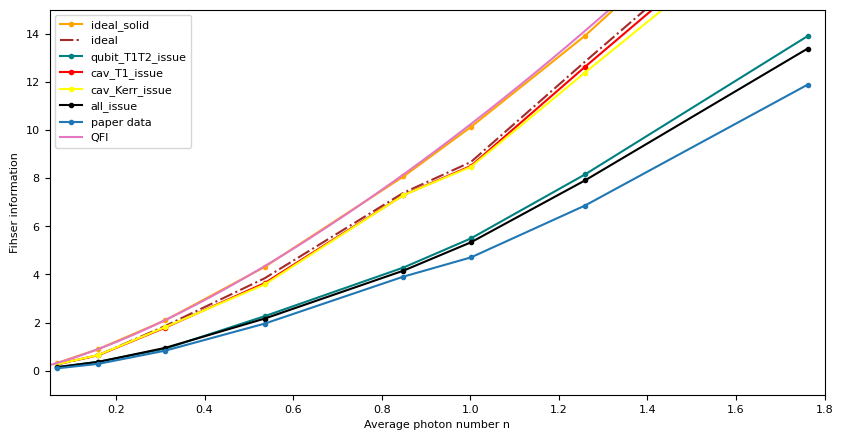

In [26]:
alpha_sim_ideal_solid = {
    '0.5': 'pe/sim/errorbudget/ideal_solid/0_plus_alpha05_ideal_solid.npz',
    '0.75': 'pe/sim/errorbudget/ideal_solid/0_plus_alpha075_ideal_solid.npz',
    '1': 'pe/sim/errorbudget/ideal_solid/0_plus_alpha1_ideal_solid.npz',
    '1.25': 'pe/sim/errorbudget/ideal_solid/0_plus_alpha125_ideal_solid.npz',
    '1.5': 'pe/sim/errorbudget/ideal_solid/0_plus_alpha15_ideal_solid.npz',
    '1.6': 'pe/sim/errorbudget/ideal_solid/0_plus_alpha16_ideal_solid.npz',
    '1.75': 'pe/sim/errorbudget/ideal_solid/0_plus_alpha175_ideal_solid.npz',
    '2': 'pe/sim/errorbudget/ideal_solid/0_plus_alpha2_ideal_solid.npz',
}
alpha_sim_ideal = {
    '0.5': 'pe/sim/errorbudget/ideal/0_plus_alpha05_ideal.npz',
    '0.75': 'pe/sim/errorbudget/ideal/0_plus_alpha075_ideal.npz',
    '1': 'pe/sim/errorbudget/ideal/0_plus_alpha1_ideal.npz',
    '1.25': 'pe/sim/errorbudget/ideal/0_plus_alpha125_ideal.npz',
    '1.5': 'pe/sim/errorbudget/ideal/0_plus_alpha15_ideal.npz',
    '1.6': 'pe/sim/errorbudget/ideal/0_plus_alpha16_ideal.npz',
    '1.75': 'pe/sim/errorbudget/ideal/0_plus_alpha175_ideal.npz',
    '2': 'pe/sim/errorbudget/ideal/0_plus_alpha2_ideal.npz',
}
alpha_sim_qT1T2 = {
    '0.5': 'pe/sim/errorbudget/q_T1T2_issue/0_plus_alpha05_qT1T2_issue.npz',
    '0.75': 'pe/sim/errorbudget/q_T1T2_issue/0_plus_alpha075_qT1T2_issue.npz',
    '1': 'pe/sim/errorbudget/q_T1T2_issue/0_plus_alpha1_qT1T2_issue.npz',
    '1.25': 'pe/sim/errorbudget/q_T1T2_issue/0_plus_alpha125_qT1T2_issue.npz',
    '1.5': 'pe/sim/errorbudget/q_T1T2_issue/0_plus_alpha15_qT1T2_issue.npz',
    '1.6': 'pe/sim/errorbudget/q_T1T2_issue/0_plus_alpha16_qT1T2_issue.npz',
    '1.75': 'pe/sim/errorbudget/q_T1T2_issue/0_plus_alpha175_qT1T2_issue.npz',
    '2': 'pe/sim/errorbudget/q_T1T2_issue/0_plus_alpha2_qT1T2_issue.npz',
}
alpha_sim_cT1 = {
    '0.5': 'pe/sim/errorbudget/c_T1_issue/0_plus_alpha05_cT1_issue.npz',
    '0.75': 'pe/sim/errorbudget/c_T1_issue/0_plus_alpha075_cT1_issue.npz',
    '1': 'pe/sim/errorbudget/c_T1_issue/0_plus_alpha1_cT1_issue.npz',
    '1.25': 'pe/sim/errorbudget/c_T1_issue/0_plus_alpha125_cT1_issue.npz',
    '1.5': 'pe/sim/errorbudget/c_T1_issue/0_plus_alpha15_cT1_issue.npz',
    '1.6': 'pe/sim/errorbudget/c_T1_issue/0_plus_alpha16_cT1_issue.npz',
    '1.75': 'pe/sim/errorbudget/c_T1_issue/0_plus_alpha175_cT1_issue.npz',
    '2': 'pe/sim/errorbudget/c_T1_issue/0_plus_alpha2_cT1_issue.npz',
}
alpha_sim_c_Kerr = {
    '0.5': 'pe/sim/errorbudget/c_Kerr_issue/0_plus_alpha05_cKerr_issue.npz',
    '0.75': 'pe/sim/errorbudget/c_Kerr_issue/0_plus_alpha075_cKerr_issue.npz',
    '1': 'pe/sim/errorbudget/c_Kerr_issue/0_plus_alpha1_cKerr_issue.npz',
    '1.25': 'pe/sim/errorbudget/c_Kerr_issue/0_plus_alpha125_cKerr_issue.npz',
    '1.5': 'pe/sim/errorbudget/c_Kerr_issue/0_plus_alpha15_cKerr_issue.npz',
    '1.6': 'pe/sim/errorbudget/c_Kerr_issue/0_plus_alpha16_cKerr_issue.npz',
    '1.75': 'pe/sim/errorbudget/c_Kerr_issue/0_plus_alpha175_cKerr_issue.npz',
    '2': 'pe/sim/errorbudget/c_Kerr_issue/0_plus_alpha2_cKerr_issue.npz',
}

alpha_sim_all = {
    '0.5': 'pe/sim/errorbudget/all_issue/0_plus_alpha05_all_issue.npz',
    '0.75': 'pe/sim/errorbudget/all_issue/0_plus_alpha075_all_issue.npz',
    '1': 'pe/sim/errorbudget/all_issue/0_plus_alpha1_all_issue.npz',
    '1.25': 'pe/sim/errorbudget/all_issue/0_plus_alpha125_all_issue.npz',
    '1.5': 'pe/sim/errorbudget/all_issue/0_plus_alpha15_all_issue.npz',
    '1.6': 'pe/sim/errorbudget/all_issue/0_plus_alpha16_all_issue.npz',
    '1.75': 'pe/sim/errorbudget/all_issue/0_plus_alpha175_all_issue.npz',
    '2': 'pe/sim/errorbudget/all_issue/0_plus_alpha2_all_issue.npz',
}

# SCS exp_sim error budge

result_sim_max_ideal_solid = []
result_sim_max_ideal= []
result_sim_max_qT1T2 = []
result_sim_max_cT1 = []
result_sim_max_c_Kerr = []
result_sim_max_all = []


ax0, fig = plt.subplots(figsize=(10,5))

for alpha in alpha_data:
    # np.max(data.x) - 0.1 if (np.max(data.x) < 3) else 3
    up_lim = 1.6 if float(alpha) > 1 else np.max(data.x) - 0.1
    x_dense = np.linspace(min(theta_list), up_lim, 2000)

    # simulation: ideal solid
    if 1:
        # print('only kerr')
        sim = np.load(alpha_sim_ideal_solid[alpha], 'r')
        # print(alpha)
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        result_sim_max_ideal_solid.append(m)
   

    # simulation: ideal
    if 1:
        sim = np.load(alpha_sim_ideal[alpha], 'r')
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        result_sim_max_ideal.append(m)
      

    # simulation: qubit T1 T2
        sim = np.load(alpha_sim_qT1T2[alpha], 'r')
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        result_sim_max_qT1T2.append(m)
     

    # simulation: cav T1
    if 1:
        sim = np.load(alpha_sim_cT1[alpha], 'r')
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        result_sim_max_cT1.append(m)
    

    # simulation: cav self-Kerr
    if 1:
        sim = np.load(alpha_sim_c_Kerr[alpha], 'r')
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        result_sim_max_c_Kerr.append(m)

    # simulation: all issue
        sim = np.load(alpha_sim_all[alpha], 'r')
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        result_sim_max_all.append(m)
       
 

n = [compute_photon_number(v) for v in np_alphas]
v = np.linspace(0,2,200)

# Fisher information plot

plt.plot(n, result_sim_max_ideal_solid, '.-', color='orange', label="ideal_solid")
plt.plot(n, result_sim_max_ideal, '-.', color='brown', label="ideal")
plt.plot(n, result_sim_max_qT1T2, '.-', color='teal', label="qubit_T1T2_issue")
plt.plot(n, result_sim_max_cT1, '.-', color='red', label="cav_T1_issue")
plt.plot(n, result_sim_max_c_Kerr, '.-', color='yellow', label="cav_Kerr_issue")
plt.plot(n, result_sim_max_all, '.-', color='black', label="all_issue")


# plt.errorbar(x_data, y_data, yerr=result_sigma,  linestyle='', color='tab:blue', markersize=4, marker='o', capsize=4, label='SCS')
# plt.plot(v, y_fit, ':', color='tab:blue')
# plt.errorbar(x_data, y_sql, yerr=coh_sigma, linestyle='', color='tab:purple', markersize=4, marker='d', capsize=4, label='classical')
# plt.plot(v, y_sql_fit, ':', color='tab:purple')
plt.plot(n, result_sim_max, '.-', color='tab:blue', label='paper data')
# plt.plot(n, coh_sim_max, '--', color='tab:purple', label='simulation')


v = np.linspace(0, 4, 200)
plt.plot([compute_photon_number(w) for w in v], [compute_max_Fq(w) for w in v], color='tab:pink', label="QFI")

plt.xlabel(r"Average photon number n")
plt.ylabel("Fihser information")
plt.legend()
plt.xlim(0.05,1.8)
plt.ylim(-1, 15)
plt.show()

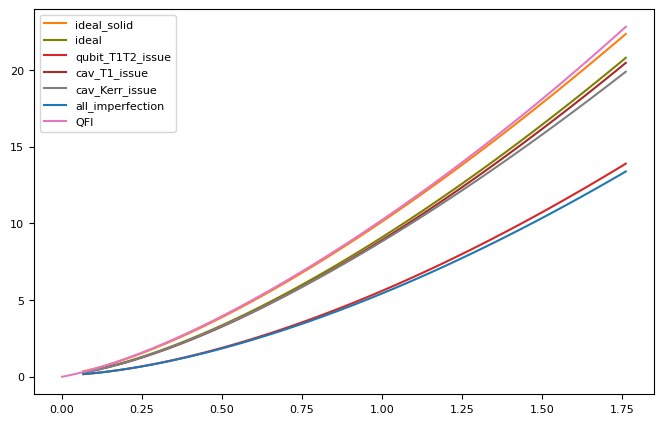

In [28]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Provided x values and multiple sets of y values
x_data = np.array([0.06640117167171947, 0.16027105821023155, 0.311229665600927, 0.5358980117251503,
                   0.8492793602260809, 1.0015357138215844, 1.258977106111736, 1.761594155955764])

# Multiple sets of y values

y_datasets = [
    result_sim_max_ideal_solid,
    result_sim_max_ideal,
    result_sim_max_qT1T2,
    result_sim_max_cT1,
    result_sim_max_c_Kerr,
    result_sim_max_all
]

# Labels for each dataset
y_labels = [
    "ideal_solid",
    "ideal",
    "qubit_T1T2_issue",
    "cav_T1_issue",
    "cav_Kerr_issue",
    'all_imperfection'
]

y_data_fit ={ }

colors = ['tab:orange', 'olive', 'tab:red', 'brown','tab:gray','tab:blue']

# Define the model function
def model(x, a, b, c):
    return a * x**b + c

# Prepare plot
# plt.figure(figsize=(8*cm, 5*cm))
plt.figure(figsize=(8, 5))

# Loop over each y dataset, fit the curve, and plot the results with the specified labels
for label, y_data, color in zip(y_labels, y_datasets, colors):
    # Fit the data to the model
    params, _ = curve_fit(model, x_data, y_data, p0=[1, 1, 1])
    a, b, c = params
    
    # Generate data for the fitted curve
    x_fit = np.linspace(min(x_data), max(x_data), 100)
    y_fit = model(x_fit, a, b, c)
    y_data_fit[label] = y_fit
    
    # Plot the data points and fitted curve
    # plt.scatter(x_data, y_data, label=f"{label} (Data)")
    # plt.plot(x_fit, y_fit, label=f"{label} Fit: y = {a:.2f} * x^{b:.2f} + {c:.2f}")
    plt.plot(x_fit, y_fit, '-', color=color, label=f"{label}")

v = np.linspace(0, 2, 200)
plt.plot([compute_photon_number(w) for w in v], [compute_max_Fq(w) for w in v], color='tab:pink', label="QFI")
# plt.plot(sqvac_x_fit, sqvac_data_fit['sqvac_all_imperfection'])
plt.legend()






In [13]:
y_data_fit['ideal']

array([ 0.30500799,  0.37103382,  0.44385505,  0.52283274,  0.6074767 ,
        0.69739559,  0.79226762,  0.89182227,  0.99582792,  1.10408347,
        1.21641213,  1.33265693,  1.45267731,  1.57634643,  1.70354909,
        1.83418009,  1.96814282,  2.10534819,  2.24571371,  2.3891627 ,
        2.53562365,  2.68502966,  2.83731799,  2.99242961,  3.1503089 ,
        3.3109033 ,  3.47416303,  3.64004089,  3.80849204,  3.97947378,
        4.15294542,  4.32886811,  4.50720471,  4.68791967,  4.87097893,
        5.0563498 ,  5.24400087,  5.43390196,  5.62602401,  5.82033903,
        6.01682003,  6.21544096,  6.41617666,  6.61900281,  6.8238959 ,
        7.03083315,  7.2397925 ,  7.45075259,  7.66369267,  7.87859262,
        8.09543291,  8.31419455,  8.53485909,  8.75740858,  8.98182556,
        9.20809303,  9.43619441,  9.66611359,  9.89783482, 10.13134277,
       10.36662246, 10.60365929, 10.842439  , 11.08294764, 11.3251716 ,
       11.56909758, 11.81471257, 12.06200383, 12.31095891, 12.56

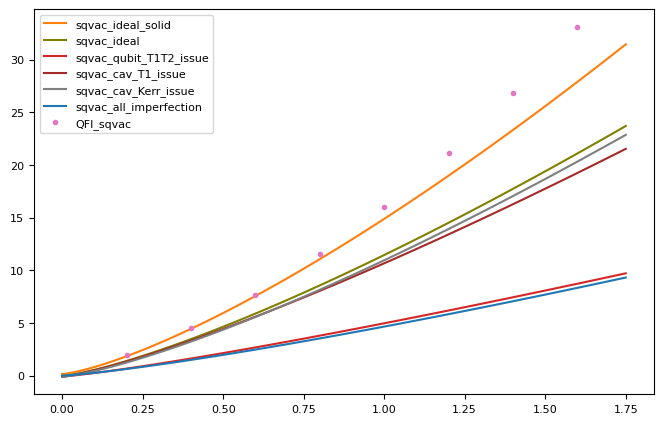

In [29]:
# ------------------ sqvac  with N= 0.2 0.4 0.6 0.8 1 1.2 1.4--------------------------------------

sqvac_sim_ideal_solid = {
    '0.2': 'pe/sim/errorbudget/sqvac_ideal_solid/sqvac_n02_ideal_solid.npz',
    '0.4': 'pe/sim/errorbudget/sqvac_ideal_solid/sqvac_n04_ideal_solid.npz',
    '0.6': 'pe/sim/errorbudget/sqvac_ideal_solid/sqvac_n06_ideal_solid.npz',
    '0.8': 'pe/sim/errorbudget/sqvac_ideal_solid/sqvac_n08_ideal_solid.npz',
    '1.0': 'pe/sim/errorbudget/sqvac_ideal_solid/sqvac_n1_ideal_solid.npz',
    '1.2': 'pe/sim/errorbudget/sqvac_ideal_solid/sqvac_n12_ideal_solid.npz',
    '1.4': 'pe/sim/errorbudget/sqvac_ideal_solid/sqvac_n14_ideal_solid.npz',
    '1.6': 'pe/sim/errorbudget/sqvac_ideal_solid/sqvac_n16_ideal_solid.npz',


}

sqvac_sim_ideal = {
    '0.2': 'pe/sim/errorbudget/sqvac_ideal/sqvac_n02_ideal.npz',
    '0.4': 'pe/sim/errorbudget/sqvac_ideal/sqvac_n04_ideal.npz',
    '0.6': 'pe/sim/errorbudget/sqvac_ideal/sqvac_n06_ideal.npz',
    '0.8': 'pe/sim/errorbudget/sqvac_ideal/sqvac_n08_ideal.npz',
    '1.0': 'pe/sim/errorbudget/sqvac_ideal/sqvac_n1_ideal.npz',
    '1.2': 'pe/sim/errorbudget/sqvac_ideal/sqvac_n12_ideal.npz',
    '1.4': 'pe/sim/errorbudget/sqvac_ideal/sqvac_n14_ideal.npz',
    '1.6': 'pe/sim/errorbudget/sqvac_ideal/sqvac_n16_ideal.npz'

}

sqvac_sim_qT1T2 = {
    '0.2': 'pe/sim/errorbudget/sqvac_q_T1T2_issue/sqvac_n02_qT1T2_issue.npz',
    '0.4': 'pe/sim/errorbudget/sqvac_q_T1T2_issue/sqvac_n04_qT1T2_issue.npz',
    '0.6': 'pe/sim/errorbudget/sqvac_q_T1T2_issue/sqvac_n06_qT1T2_issue.npz',
    '0.8': 'pe/sim/errorbudget/sqvac_q_T1T2_issue/sqvac_n08_qT1T2_issue.npz',
    '1.0': 'pe/sim/errorbudget/sqvac_q_T1T2_issue/sqvac_n1_qT1T2_issue.npz',
    '1.2': 'pe/sim/errorbudget/sqvac_q_T1T2_issue/sqvac_n12_qT1T2_issue.npz',
    '1.4': 'pe/sim/errorbudget/sqvac_q_T1T2_issue/sqvac_n14_qT1T2_issue.npz',
    '1.6': 'pe/sim/errorbudget/sqvac_q_T1T2_issue/sqvac_n16_qT1T2_issue.npz',
}

sqvac_sim_cT1 = {
    '0.2': 'pe/sim/errorbudget/sqvac_c_T1_issue/sqvac_n02_cT1_issue.npz',
    '0.4': 'pe/sim/errorbudget/sqvac_c_T1_issue/sqvac_n04_cT1_issue.npz',
    '0.6': 'pe/sim/errorbudget/sqvac_c_T1_issue/sqvac_n06_cT1_issue.npz',
    '0.8': 'pe/sim/errorbudget/sqvac_c_T1_issue/sqvac_n08_cT1_issue.npz',
    '1.0': 'pe/sim/errorbudget/sqvac_c_T1_issue/sqvac_n1_cT1_issue.npz',
    '1.2': 'pe/sim/errorbudget/sqvac_c_T1_issue/sqvac_n12_cT1_issue.npz',
    '1.4': 'pe/sim/errorbudget/sqvac_c_T1_issue/sqvac_n14_cT1_issue.npz',
    '1.6': 'pe/sim/errorbudget/sqvac_c_T1_issue/sqvac_n16_cT1_issue.npz',
}

sqvac_sim_c_Kerr = {
    '0.2': 'pe/sim/errorbudget/sqvac_c_Kerr_issue/sqvac_n02_cKerr_issue.npz',
    '0.4': 'pe/sim/errorbudget/sqvac_c_Kerr_issue/sqvac_n04_cKerr_issue.npz',
    '0.6': 'pe/sim/errorbudget/sqvac_c_Kerr_issue/sqvac_n06_cKerr_issue.npz',
    '0.8': 'pe/sim/errorbudget/sqvac_c_Kerr_issue/sqvac_n08_cKerr_issue.npz',
    '1.0': 'pe/sim/errorbudget/sqvac_c_Kerr_issue/sqvac_n1_cKerr_issue.npz',
    '1.2': 'pe/sim/errorbudget/sqvac_c_Kerr_issue/sqvac_n12_cKerr_issue.npz',
    '1.4': 'pe/sim/errorbudget/sqvac_c_Kerr_issue/sqvac_n14_cKerr_issue.npz',
    '1.6': 'pe/sim/errorbudget/sqvac_c_Kerr_issue/sqvac_n16_cKerr_issue.npz',
}

sqvac_sim_all = {
    '0.2': 'pe/sim/errorbudget/sqvac_all_issue/sqvac_n02_all_issue.npz',
    '0.4': 'pe/sim/errorbudget/sqvac_all_issue/sqvac_n04_all_issue.npz',
    '0.6': 'pe/sim/errorbudget/sqvac_all_issue/sqvac_n06_all_issue.npz',
    '0.8': 'pe/sim/errorbudget/sqvac_all_issue/sqvac_n08_all_issue.npz',
    '1.0': 'pe/sim/errorbudget/sqvac_all_issue/sqvac_n1_all_issue.npz',
    '1.2': 'pe/sim/errorbudget/sqvac_all_issue/sqvac_n12_all_issue.npz',
    '1.4': 'pe/sim/errorbudget/sqvac_all_issue/sqvac_n14_all_issue.npz',
    '1.6': 'pe/sim/errorbudget/sqvac_all_issue/sqvac_n16_all_issue.npz',
}


# 
sqvac_sim_max_ideal_solid = []
sqvac_sim_max_ideal= []
sqvac_sim_max_qT1T2 = []
sqvac_sim_max_cT1 = []
sqvac_sim_max_c_Kerr = []
sqvac_sim_max_all = []

sqvac_x = np.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])
for k in sqvac_x:
    # ideal solide
    if 1:
        sim = np.load(sqvac_sim_ideal_solid[str(k)])
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        sqvac_sim_max_ideal_solid.append(m)
    # ideal
    if 1:
        sim = np.load(sqvac_sim_ideal[str(k)])
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        sqvac_sim_max_ideal.append(m)
    # qT1T2
    if 1:
        sim = np.load(sqvac_sim_qT1T2[str(k)])
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        sqvac_sim_max_qT1T2.append(m)
    # cT1
    if 1:
        sim = np.load(sqvac_sim_cT1[str(k)])
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        sqvac_sim_max_cT1.append(m)
    # cKerr
    if 1:
        sim = np.load(sqvac_sim_c_Kerr[str(k)])
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        sqvac_sim_max_c_Kerr.append(m)
    # all
    if 1:
        sim = np.load(sqvac_sim_all[str(k)])
        phase_sim = sim['x']
        pe_sim = sim['probability_sim']
        x_sim = phase_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        y_sim = pe_sim[phase_sim <= max(x_dense) if alpha != '2.5' else phase_sim <= 0.6]
        m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[alpha])
        sqvac_sim_max_all.append(m)

y_datasets_sqvac = [
    sqvac_sim_max_ideal_solid,
    sqvac_sim_max_ideal,
    sqvac_sim_max_qT1T2,
    sqvac_sim_max_cT1,
    sqvac_sim_max_c_Kerr,
    sqvac_sim_max_all
]

y_labels_sqvac = [
    "sqvac_ideal_solid",
    "sqvac_ideal",
    "sqvac_qubit_T1T2_issue",
    "sqvac_cav_T1_issue",
    "sqvac_cav_Kerr_issue",
    'sqvac_all_imperfection'
]

sqvac_data_fit ={

}


plt.figure(figsize=(8, 5))

for label, sqvac_data, color in zip(y_labels_sqvac, y_datasets_sqvac, colors):
    # Fit the data to the model
    params, _ = curve_fit(model, sqvac_x, sqvac_data, p0=[1, 1, 1])
    a, b, c = params
    
    # Generate data for the fitted curve
    # sqvac_x_fit = np.linspace(min(sqvac_x), max(sqvac_x), 100)
    sqvac_x_fit = np.linspace(0, 1.75, 100)
    sqvac_y_fit = model(sqvac_x_fit, a, b, c)

    sqvac_data_fit[label] = sqvac_y_fit
    
    # Plot the data points and fitted curve
    # plt.plot(sqvac_x, sqvac_data,'.', color=color,label=f"{label} (Data)")
    # print(np.shape(y_data))
    # print(np.shape(sqvac_x))
    # plt.plot(x_fit, y_fit, '--',label=f"{label} Fit: y = {a:.2f} * x^{b:.2f} + {c:.2f}")
    plt.plot(sqvac_x_fit, sqvac_y_fit, '-', color=color, label=f"{label}")
    

s_coeff = np.array([ 0.43351, 0.59646, 0.71271, 0.805, 0.88141, 0.94732, 1.00529, 1.05731     ])
QFI_sqvac = np.array( [compute_max_Fq_sqvac(value) for value in s_coeff] )
# params, _ = curve_fit(model, s_coeff, QFI_sqvac)
# a, b, c = params
# QFI_sqvac_fit = model(sqvac_x_fit, a, b, c, p0 =[])

plt.plot(sqvac_x, QFI_sqvac, '.', color='tab:pink', label="QFI_sqvac")
# plt.plot(sqvac_x_fit, QFI_sqvac_fit, '.', color='tab:pink', label="QFI_sqvac")
plt.legend()

In [15]:
compute_max_Fq_sqvac(np.array(1))

26.235391954955706

#### plot SCS and sqvac simulation together

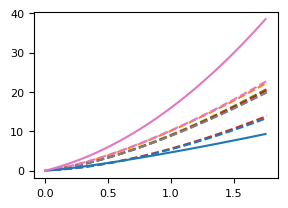

In [30]:
scs_y_fit = y_data_fit
scs_x_fit = x_fit

sqvac_y_fit = sqvac_data_fit
sqvac_x_fit = sqvac_x_fit

cm = 0.393701
plt.figure(figsize=(8*cm, 5.5*cm))


colors = ['tab:orange', 'olive', 'tab:red', 'brown','tab:gray','tab:blue']

# # scs
plt.plot(scs_x_fit, scs_y_fit['ideal_solid'], '--', color = colors[0], label='ideal_solid')
plt.plot(scs_x_fit, scs_y_fit['ideal'], '--', color = colors[1], label='ideal')
plt.plot(scs_x_fit, scs_y_fit['qubit_T1T2_issue'], '--', color = colors[2], label='qubit_T1T2_issue')
plt.plot(scs_x_fit, scs_y_fit['cav_T1_issue'], '--',color = colors[3],  label='cav_T1_issue')
plt.plot(scs_x_fit, scs_y_fit['cav_Kerr_issue'], '--',color = colors[4],  label='cav_Kerr_issue')
plt.plot(scs_x_fit, scs_y_fit['all_imperfection'], '--', color = colors[5], label='all_imperfection')

plt.plot([compute_photon_number(w) for w in v], [compute_max_Fq(w) for w in v], '--',color='tab:pink', label="QFI")
# # sqvac
# plt.plot(sqvac_x_fit, sqvac_y_fit['sqvac_ideal_solid'], '-', color = colors[0], label='sqvac_ideal_solid')
# plt.plot(sqvac_x_fit, sqvac_y_fit['sqvac_ideal'], '-', color = colors[1], label='sqvac_ideal')
# plt.plot(sqvac_x_fit, sqvac_y_fit['sqvac_qubit_T1T2_issue'], '-', color = colors[2], label='sqvac_qubit_T1T2_issue')
# plt.plot(sqvac_x_fit, sqvac_y_fit['sqvac_cav_T1_issue'], '-', color = colors[3], label='sqvac_cav_T1_issue')
# plt.plot(sqvac_x_fit, sqvac_y_fit['sqvac_cav_Kerr_issue'], '-', color = colors[4], label='sqvac_cav_Kerr_issue')
plt.plot(sqvac_x_fit, sqvac_y_fit['sqvac_all_imperfection'], '-', color = colors[5], label='sqvac_all_imperfection')
# plt.plot(sqvac_x, [compute_max_Fq_sqvac(value) for value in s_coeff], color='tab:pink', label="QFI_sqvac")

def compute_QFI_sqvac(num_avg):
    return 8*num_avg**2+8*num_avg

plt.plot(sqvac_x_fit, compute_QFI_sqvac(sqvac_x_fit), '-', color='tab:pink', label="QFI_sqvac")


# plt.legend()
plt.savefig('error_budget.pdf')
# plt.xlim(0.2, 1.6)




In [29]:
index_scs = np.argmin(np.abs(scs_x_fit - 1.76))
index_sqvac = np.argmin(np.abs(sqvac_x_fit - 1.76 ))

print('scs grape ideal',scs_y_fit['ideal'][index_scs])
print('scs grape qT1T2',scs_y_fit['qubit_T1T2_issue'][index_scs])
print('scs grape Kerr',scs_y_fit['cav_Kerr_issue'][index_scs])
print('scs grape all imperfection',scs_y_fit['all_imperfection'][index_scs])

print('sqvac grape ideal',sqvac_y_fit['sqvac_ideal'][index_scs])
print('sqvac grape qT1T2',sqvac_y_fit['sqvac_qubit_T1T2_issue'][index_scs])
print('sqvac grape Kerr',sqvac_y_fit['sqvac_cav_Kerr_issue'][index_scs])
print('sqvac grape all imperfection',sqvac_y_fit['sqvac_all_imperfection'][index_sqvac])

scs grape ideal 20.796088738239487
scs grape qT1T2 13.896007442882242
scs grape Kerr 19.89101648569366
scs grape all imperfection 13.384952050571101
sqvac grape ideal 23.71001296535864
sqvac grape qT1T2 9.710962812151466
sqvac grape Kerr 22.867035964898317
sqvac grape all imperfection 9.311114259540492


### 计算压缩真空态的平均光子数目

In [36]:
def compute_photon_number_sqvac(z):
    cdim = 30
    psi = squeeze(cdim,z) * coherent(cdim,0)
    a = destroy(cdim)
    return np.abs(np.array(psi.dag() * a.dag()*a * psi))

print('1.10404:',compute_photon_number_sqvac(1.10404))
print('1.10404:',compute_photon_number_sqvac(1.09501))
print('1.05731:',compute_photon_number_sqvac(1.05731))
print('1.00529:',compute_photon_number_sqvac(1.00529))
print('0.94732:',compute_photon_number_sqvac(0.94732))
print('0.88141:',compute_photon_number_sqvac(0.88141))
# print(compute_photon_number_sqvac(0.659))
print('0.805:',compute_photon_number_sqvac(0.805))
print('0.71271:',compute_photon_number_sqvac(0.71271))
print('0.59646:',compute_photon_number_sqvac( 0.59646))
print('0.43351',compute_photon_number_sqvac(0.43351))

1.10404: 1.8000967382987652
1.10404: 1.7601516513879034
1.05731: 1.6008924881152677
1.00529: 1.4000468795782446
0.94732: 1.2000250731107833
0.88141: 1.0000789383515607
0.805: 0.8006713613912796
0.71271: 0.6000027929717978
0.59646: 0.4000069338062937
0.43351 0.2000025834906587


## Appendix data plot

### Fig 14

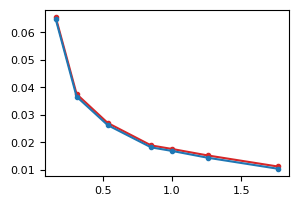

In [244]:
import pandas as pd
file_CR = pd.read_csv('figure_14/dphivsnBayesian.csv')
file_CFI = pd.read_csv('figure_14/dphivsnCFIp1.csv')
avg_num = file_CFI.iloc[:,0]
CR = file_CR.iloc[:,1]
CFI = file_CFI.iloc[:,1]
# 'data plot'
cm = 0.393701
plt.figure(figsize=(8*cm, 5.5*cm))
plt.plot(avg_num, CR, '.-',color='tab:red' )
plt.plot(avg_num, CFI, '.-',color='tab:blue' )
plt.savefig('fig14.pdf')

### Fig 15

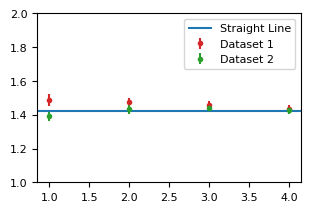

In [253]:
import re

# Function to parse "Around[mean, uncertainty]" and handle complex numbers
def parse_around_column(column):
    means = []
    uncertainties = []
    for value in column:
        # Handle scientific notation
        value = value.replace('*^-', 'e-')
        
        # Match the "Around[mean, uncertainty]" format
        match = re.match(r"Around\[(.*?),\s*(.*?)\]", value)
        if match:
            mean = float(match.group(1).strip())  # Always convert mean to float
            uncertainty = match.group(2).strip()
            
            # If uncertainty contains a complex number, set it to 0
            if 'I' in uncertainty:
                uncertainty = 0.0
            else:
                uncertainty = float(uncertainty)  # Otherwise, convert uncertainty to float
            
            means.append(mean)
            uncertainties.append(uncertainty)
        else:
            raise ValueError(f"Invalid format: {value}")
    
    return np.array(means), np.array(uncertainties)


file_alpha1 = pd.read_csv('figure_15/datadchiadaptive.csv')
file_alpha2 = pd.read_csv('figure_15/datadchiadaptive2.csv') 
y1, var_y1 = parse_around_column(file_alpha1.iloc[:, 1])
y2, var_y2 = parse_around_column(file_alpha2.iloc[:, 1])

straight_line_value = 2 * np.pi * 1.423 /1000
x_vec = np.array([1, 2, 3, 4])

# 
y1 = y1/(2*np.pi)*1000
var_y1 = var_y1/(2*np.pi)*1000
y2 = y2/(2*np.pi)*1000
var_y2 = var_y2/(2*np.pi)*1000
straight_line_value = straight_line_value/(2*np.pi)*1000



# Plot
cm = 0.393701
plt.figure(figsize=(8 * cm, 5.5 * cm))
plt.errorbar(x_vec, y1, yerr=var_y1/(2), fmt='.', color='tab:red', label='Dataset 1')
plt.errorbar(x_vec, y2, yerr=var_y2, fmt='.', color='tab:green', label='Dataset 2')
plt.axhline(y=straight_line_value, color='tab:blue', linestyle='-', label='Straight Line')
# plt.xlabel('X-axis Label')
# plt.ylabel('Y-axis Label')
plt.ylim([1, 2])
plt.legend()
plt.tight_layout()
plt.savefig('fig15.pdf')
plt.show()


### Fig 12

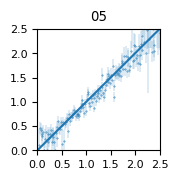

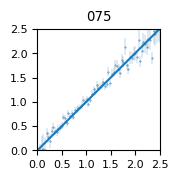

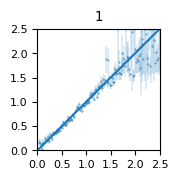

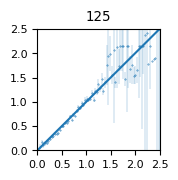

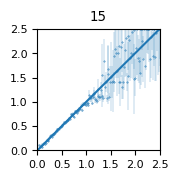

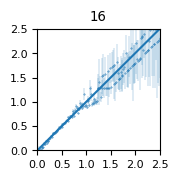

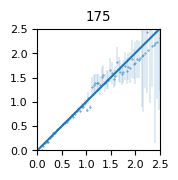

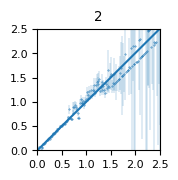

In [239]:
file_paths = [
    'figure_12/estimationtab05.csv',
    'figure_12/estimationtab075.csv',
    'figure_12/estimationtab1.csv',
    'figure_12/estimationtab125p.csv',
    'figure_12/estimationtab15.csv',
    'figure_12/estimationtab16.csv',
    'figure_12/estimationtab175.csv',
    'figure_12/estimationtab2.csv'
]
fig_names = ['05', '075', '1', '125', '15', '16', '175', '2']
for i, file_path in enumerate(file_paths):
    file = pd.read_csv(file_path)
    x = file.iloc[:, 0]
    # print(x)
    y, var_y = parse_around_column(file.iloc[:, 1])
    cm = 0.393701
    plt.figure(figsize=(4 * cm, 4 * cm))
    plt.errorbar(x, y, yerr=var_y, fmt='.', color = 'tab:blue', elinewidth=0.2, markersize =0.7)
    
    ticks = [0, 0.5, 1, 1.5, 2, 2.5]
    # plt.xticks(ticks,labels=[])  # Set x-axis ticks
    # plt.yticks(ticks,labels=[] )  # Set y-axis ticks
    plt.xticks(ticks)  # Set x-axis ticks
    plt.yticks(ticks)  # Set y-axis ticks
    plt.xlim(0, 2.5)
    plt.ylim(0, 2.5)
    plt.title(f'{fig_names[i]}')
    x_line = np.linspace(0, 2.5, 200)
    y_line = np.linspace(0, 2.5, 200)
    plt.plot(x_line, y_line, '-', color='tab:blue')
    plt.savefig(f'fig12_{fig_names[i]}.pdf')
    


### Fig 13

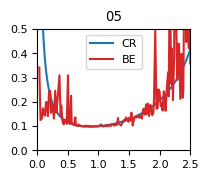

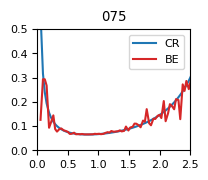

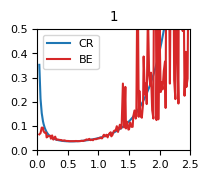

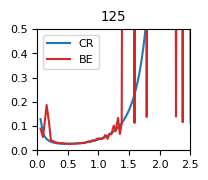

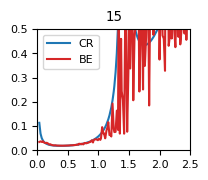

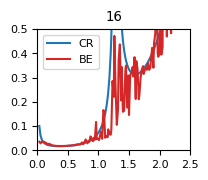

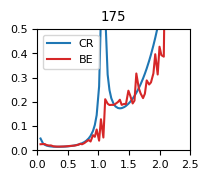

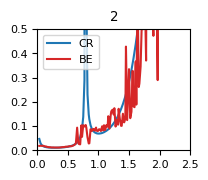

In [240]:
file_path1 = [
    'figure_13/dphiCFIPtab05.csv',
    'figure_13/dphiCFIPfit075.csv',
    'figure_13/dphiCFIPfit1.csv',
    'figure_13/dphiCFIPfit125.csv',
    'figure_13/dphiCFIPfit15.csv',
    'figure_13/dphiCFIPfit16.csv',
    'figure_13/dphiCFIPtabα175lowpass2.csv',
    # 'figure_13/dphiCFIPtab175.csv',
    'figure_13/dphiCFIPtab2.csv',
]
file_path2 = [
    'figure_13/uncertaintytab05.csv',
    'figure_13/uncertaintytab075.csv',
    'figure_13/uncertaintytab1.csv',
    'figure_13/uncertaintytab125.csv',
    'figure_13/uncertaintytab15.csv',
    'figure_13/uncertaintytab16.csv',
    'figure_13/uncertaintytab175.csv',
    'figure_13/uncertaintytab2.csv',
]
fig_names = ['05', '075', '1', '125', '15', '16', '175', '2']
for i in range(len(file_path1)):
    # print(i)
    file1 = pd.read_csv(file_path1[i])
    file2 = pd.read_csv(file_path2[i])
    x = file1.iloc[:, 0]
    y1 = file1.iloc[:, 1]
    y2 = file2.iloc[:, 1]

    y2 = y2.apply(str)
    y2 = y2.str.replace(r'\*I', 'j', regex=True)
    y2 = y2.apply(lambda val: abs(complex(val) if 'j' in val else abs(float(val))))


    # data plot
    cm = 0.393701
    plt.figure(figsize=(5 * cm, 4 * cm))
    plt.plot(x, y1, '-', color = 'tab:blue', label = 'CR')
    plt.plot(x, y2, '-', color = 'tab:red', label = 'BE')
    xticks = [0, 0.5, 1, 1.5, 2, 2.5]
    plt.xticks(xticks)
    plt.ylim(0, 0.5)
    plt.xlim(0, 2.5)
    plt.title(f'{fig_names[i]}')
    plt.legend()
    plt.savefig(f'fig13_{fig_names[i]}.pdf')


In [225]:
file = pd.read_csv( 'figure_13/dphiCFIPtab175.csv')
x = file.iloc[:, 0]
y = file.iloc[:, 1]